In [1]:
from imports import *

In [2]:
# GLOBAL PARAMETERS
today = datetime.now().strftime('%Y-%m-%d') # For printing/filenames
path = r'C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures'
pdf_path = os.path.join(path, f'{today}_ML_TA_MultipleStocks.pdf')

plt.rcParams['font.family'] = 'Segoe UI Emoji' # Matplotlib Font Family

TICKERS = ["COIN", "TSLA", "GOOGL", "NVDA", "AAPL", "NKE", "SMCI", "BABA","XPEV", "NIO", "XYZ", "U"]
#TICKERS = ["BABA","XPEV", "NIO", "UNH"]
_Nr = 50 # Skip model if the length is this
YEARS_OF_DATA = 1
PROFIT_TARGET = 0.06
STOP_LOSS = 0.05
_DAYS = 20 # Used for SMA and training
windows = [3, 5, 7, 10, 13, 15, 17, 20] # For calculating returns
_window = 9  # Backtesting
tolerance = 1.07
_FIBS = False
_FibLen = 20 # Scan pivots for fibonacci levels
_ms = 7 # global marker size for matplotlib

# Time window
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

# Shared model components

FEATURES = [
    # Technical Indicators
    'RSI', 'RSI_SMA', 'CCI', 'OBV', '+DI', '-DI', 'ADX', 'ATR', 'VWMA', 'VI+', 'KCu', 'KCl', 'STu', 'STl', 'MFI',

    # Moving Averages & Bands
    'SMA1', 'SMA2', 'SMA3', 'SMA_Ratio', 'Upper_Band', 'Lower_Band', 'Volume_MA20',

    # Returns & Volatility
    'return1', 'return2', 'return3', 'Volatility', 'Scaled_Volatility', 'DD',

    # Volume Features
    'sumBuyVol', 'sumSellVol', 'vSpike',

    # Candlestick Patterns
    'Candlesticks', 'gapStrength',

    # Market Sentiment & Signals
    'Bear', 'Bull', 'StrongBull', 'StrongBear', 'Neutral',

    # PIVOTS
    'PP_Avg', 'R1_Avg', 'R2_Avg', 'S1_Avg', 'S2_Avg'
]

results = []

In [3]:
# Functions
def get_stock_data(ticker, start_date, end_date):
    #print("Getting data for:   ", ticker)
    df = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), 
                     interval='1d', auto_adjust=False, progress=False)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.dropna()
    return df

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=int(_DAYS*0.5)).mean()
    df['SMA2'] = df['Close'].rolling(window=_DAYS).mean()
    df['SMA3'] = df['Close'].rolling(window=int(_DAYS*2)).mean()
    df['SMA_Ratio'] = df['SMA1'] / df['SMA2']
    
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    df['RSI_SMA'] = df['RSI'] / df['RSI'].rolling(14).mean()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['buy_volume'] = (df.Close > df.Close.shift(1)) * df['Volume']
    df['sell_volume'] = (df.Close < df.Close.shift(1)) * df['Volume']
    df['sumBuyVol'] = df['buy_volume'].rolling(window=20).sum()
    df['sumSellVol'] = df['sell_volume'].rolling(window=20).sum()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    df['MFI'] = ta.calculate_mfi(df)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['return1'] = df['Close'].pct_change(9)
    df['return2'] = df['Close'].pct_change(20)
    df['return3'] = df['Close'].pct_change(50)
    df['Volatility'] = df['Close'].rolling(20).std()
    df = ta.scaled_volatility(df)
    # StrongBull, StrongBear, and Neutral as features
    df['StrongBull'] = ((df['RSI'] > 52) & (df['ADX'] > 22) & (df['sumBuyVol'] > df['sumSellVol'])).astype(int)
    df['StrongBear'] = ((df['RSI'] < 40) & (df['ADX'] > 22) & (df['sumBuyVol'] < df['sumSellVol'])).astype(int)
    df['Neutral'] = (~(df['StrongBull'].astype(bool) | df['StrongBear'].astype(bool))).astype(int)
    df['gapStrength'] = ta.compute_gapStrength(df)

    return df

def add_pivot_levels(df, window=_DAYS):
    # Compute rolling high/low/close over the window
    high = df['High'].rolling(window)
    low = df['Low'].rolling(window)
    close = df['Close'].rolling(window)
    # Classic floor trader pivots (you can adjust formulas as needed)
    PP = (high.max() + low.min() + close.apply(lambda x: x[-1])).div(3)
    R1 = 2 * PP - low.min()
    S1 = 2 * PP - high.max()
    R2 = PP + (high.max() - low.min())
    S2 = PP - (high.max() - low.min())
    # Assign to DataFrame
    df['PP'] = PP
    df['R1'] = R1
    df['S1'] = S1
    df['R2'] = R2
    df['S2'] = S2
    return df

def add_pivots(df, win=windows):
    for w in win:
        roll_high = df['High'].rolling(w)
        roll_low = df['Low'].rolling(w)
        roll_close = df['Close'].rolling(w)
        # Calculate rolling pivots
        PP = (roll_high.max() + roll_low.min() + roll_close.apply(lambda x: x[-1])).div(3)
        R1 = 2 * PP - roll_low.min()
        S1 = 2 * PP - roll_high.max()
        R2 = PP + (roll_high.max() - roll_low.min())
        S2 = PP - (roll_high.max() - roll_low.min())
        # Store in DataFrame
        df[f'PP_{w}'] = PP
        df[f'R1_{w}'] = R1
        df[f'S1_{w}'] = S1
        df[f'R2_{w}'] = R2
        df[f'S2_{w}'] = S2
    return df

def average_pivots(df, windows=[5, 10, 14, 20]):
    for level in ['PP', 'R1', 'S1', 'R2', 'S2']:
        cols = [f'{level}_{w}' for w in windows]
        # Take row-wise mean, ignore NaN for early rows
        df[f'{level}_Avg'] = df[cols].mean(axis=1)
    return df
    
def compute_expected_return(df, forward_window=14, r_cols=['R1', 'R2']):
    df['Expected_Return'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(df) - forward_window):
        current_price = close_prices[i]
        # Find resistance pivots for this row (skip if all NaN)
        pivots = [df.iloc[i][col] for col in r_cols if col in df.columns and not pd.isnull(df.iloc[i][col])]
        target_level = None
        if pivots:  # Only if we have any non-NaN pivots
            target_level = max(pivots)  # Or use your preferred pivot selection logic

        future_window = close_prices[i+1:i+1+forward_window]
        if target_level is not None:
            # Check if we hit target pivot in the window
            for j, future_price in enumerate(future_window):
                if future_price >= target_level:
                    df.iloc[i, df.columns.get_loc('Expected_Return')] = (target_level - current_price) / current_price
                    break
            else:  # If not hit
                if future_window.size > 0:
                    future_max = np.nanmax(future_window)
                    df.iloc[i, df.columns.get_loc('Expected_Return')] = (future_max - current_price) / current_price
        else:
            # No valid pivots, fall back to window max logic
            if future_window.size > 0:
                future_max = np.nanmax(future_window)
                df.iloc[i, df.columns.get_loc('Expected_Return')] = (future_max - current_price) / current_price
            else:
                df.iloc[i, df.columns.get_loc('Expected_Return')] = np.nan
    return df

def compute_expected_loss(df, forward_window=14, s_cols=['S1', 'S2']):
    df['Expected_Loss'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(df) - forward_window):
        current_price = close_prices[i]
        # Find support pivots (skip if all NaN)
        pivots = [df.iloc[i][col] for col in s_cols if col in df.columns and not pd.isnull(df.iloc[i][col])]
        target_level = None
        if pivots:
            target_level = min(pivots)  # Or your support logic

        future_window = close_prices[i+1:i+1+forward_window]
        if target_level is not None:
            # Check if we hit pivot support in window
            for j, future_price in enumerate(future_window):
                if future_price <= target_level:
                    df.iloc[i, df.columns.get_loc('Expected_Loss')] = (target_level - current_price) / current_price
                    break
            else:
                if future_window.size > 0:
                    future_min = np.nanmin(future_window)
                    df.iloc[i, df.columns.get_loc('Expected_Loss')] = (future_min - current_price) / current_price
        else:
            # No valid pivots, fallback to window min logic
            if future_window.size > 0:
                future_min = np.nanmin(future_window)
                df.iloc[i, df.columns.get_loc('Expected_Loss')] = (future_min - current_price) / current_price
            else:
                df.iloc[i, df.columns.get_loc('Expected_Loss')] = np.nan
    return df

def initialize_XGBR():
    model = XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    return model

def label_hit2(df, window=14, profit_target=0.03, stop_loss=0.03):
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(2)  # TP hit before SL
        elif sl_hit_idx is not None and (tp_hit_idx is None or sl_hit_idx < tp_hit_idx):
            labels.append(1)  # SL hit before TP
        else:
            labels.append(0)  # Neither hit

    labels += [np.nan] * window
    df['Hit_Label'] = labels
    return df

def label_hit3(df, window=14, profit_target=0.03, stop_loss=0.03):
    labels = []
    close_prices = df['Close'].values

    for i in range(window, len(close_prices)):
        entry_price = close_prices[i]
        tp = entry_price * (1 + profit_target)
        sl = entry_price * (1 - stop_loss)
        # Look BACKWARD: previous `window` bars
        past_highs = df['High'].values[i-window:i]
        past_lows = df['Low'].values[i-window:i]

        tp_hit_idx = next((j for j, price in enumerate(reversed(past_highs)) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(reversed(past_lows)) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Pad the beginning to align with df length
    labels = [np.nan]*window + labels
    df['Hit_Label'] = labels
    return df

def compute_optimal_entry(df, _DAYS=10, profit_target=0.05, stop_loss=-0.03):
    optimal_entries = []
    
    for i in range(len(df) - _DAYS):
        entry_price = df['Close'].iloc[i]
        future_data = df.iloc[i+1:i+1+_DAYS]
        
        min_price = future_data['Low'].min()  # Best possible entry
        max_price = future_data['High'].max()  # Highest possible gain

        # Check if TP or SL hit
        tp_price = entry_price * (1 + profit_target)
        sl_price = entry_price * (1 + stop_loss)

        tp_hit = (future_data['High'] >= tp_price).any()
        sl_hit = (future_data['Low'] <= sl_price).any()

        if tp_hit and not sl_hit:
            optimal_entry = min_price  # You had time to enter lower before TP
        elif sl_hit and not tp_hit:
            optimal_entry = entry_price  # Didn't get a better chance
        elif tp_hit and sl_hit:
            # Whichever came first
            first_tp_idx = future_data[future_data['High'] >= tp_price].index[0]
            first_sl_idx = future_data[future_data['Low'] <= sl_price].index[0]
            optimal_entry = min_price if first_tp_idx < first_sl_idx else entry_price
        else:
            optimal_entry = entry_price  # No TP/SL hit, assume flat

        optimal_entries.append(optimal_entry)

    # Align with DataFrame length
    df['Optimal_Entry'] = [np.nan]*_DAYS + optimal_entries
    return df

def compute_expected_entry(df, n=3):
    df['Expected_Entry'] = df['Low'].rolling(window=n, min_periods=1).min().shift(-n)
    return df
    
def label_hit(df, window=14, profit_target=0.03, stop_loss=0.03):
    """
    Label each row:
    1 = TP hit before SL
    0 = SL hit before TP or neither hit
    """
    labels = []
    close_prices = df['Close'].values

    for i in range(len(close_prices) - window):
        current_price = close_prices[i]
        tp = current_price * (1 + profit_target)
        sl = current_price * (1 - stop_loss)
        future_prices = close_prices[i + 1:i + 1 + window]

        tp_hit_idx = next((j for j, price in enumerate(future_prices) if price >= tp), None)
        sl_hit_idx = next((j for j, price in enumerate(future_prices) if price <= sl), None)

        if tp_hit_idx is not None and (sl_hit_idx is None or tp_hit_idx < sl_hit_idx):
            labels.append(1)
        else:
            labels.append(0)

    # Fill remaining with NaN to keep alignment
    labels += [np.nan] * window
    df['Hit_Label'] = labels
    return df

def get_recent_fib_levels(df, left=_FibLen, right=_FibLen):
    # Step 1: Find pivot highs/lows
    highs = df['High']
    lows = df['Low']
    is_pivot_high = highs == highs.rolling(window=left+right+1, center=True).max()
    is_pivot_low = lows == lows.rolling(window=left+right+1, center=True).min()
    is_pivot_high = is_pivot_high.fillna(False)
    is_pivot_low = is_pivot_low.fillna(False)

    # Step 2: Get most recent swing high and low
    pivot_highs = df[is_pivot_high]
    pivot_lows = df[is_pivot_low]
    if pivot_highs.empty or pivot_lows.empty:
        return None, None, None  # Not enough data

    last_high_idx = pivot_highs.index[-1]
    last_low_idx = pivot_lows.index[-1]
    high = df.loc[last_high_idx, 'High']
    low = df.loc[last_low_idx, 'Low']

    # Step 3: Calculate Fib levels
    diff = high - low
    fibs = {
        'F:0': low,
        'F:100': high,
        'F:61.8': high - 0.618 * diff,
        'F:125': high + 1.25 * diff,
        'F:-125': low - 1.25 * diff,
    }
    # For plotting, use the range between the pivots
    fib_start = min(last_high_idx, last_low_idx)
    fib_end = max(last_high_idx, last_low_idx)
    return fibs, fib_start, fib_end

def del_old_files (directory, days, exclude_extensions=None, dry_run=False):
    """Delete files older than `days` without returning a list."""
    if exclude_extensions is None:
        exclude_extensions = []

    cutoff_time = datetime.now() - timedelta(days=days)
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath) or any(filename.lower().endswith(ext.lower()) for ext in exclude_extensions):
            continue
        file_mtime = datetime.fromtimestamp(os.path.getmtime(filepath))
        if file_mtime < cutoff_time:
            if dry_run:
                print(f"[Dry Run] Would delete: {filepath}")
            else:
                try:
                    os.remove(filepath)
                    print(f"Deleted: {filepath}")
                except Exception as e:
                    print(f"Error deleting {filepath}: {e}")
#df_ticker = get_stock_data(stock, datetime.now()-timedelta(days=365), datetime.now())
#df_ticker = add_technical_indicators(df_ticker)
#plot_single_ticker(stock, df_ticker, df_results)

In [4]:
# PRICE CHARTS
def plot_single_ticker(ticker, df, df_results, _window=14):
    # Get predictions
    predictions = df_results[df_results['Ticker'] == ticker].iloc[0]
    
    # Create figure with white background
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi = 300, height_ratios=[3, 1], sharex=True)
    fig.patch.set_facecolor('white')
    
    # Get true trailing 12 months of data (not calendar YTD)
    end_date = df.index[-1]
    start_date = end_date - pd.DateOffset(months=12)
    df = df.loc[start_date:end_date]
    last_date = df.index[-1]
    current_price = round(df['Close'].iloc[-1], 2)
    
    # ===== 1. PRICE PLOT =====
    # Configure plot style
    ax1.set_facecolor('white')
    ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Historical data
    # Price is 3-days mean to avoid noise
    ax1.plot(df.index, df['Close'].rolling(3).mean(), label='Price', color='gray', alpha=0.7, linewidth=1.5)
    ax1.plot(df.index, df['SMA1'], label=f'SMA{int(_DAYS*0.5)}', color='gold', alpha=0.7, linewidth=1.2)
    ax1.plot(df.index, df['SMA2'], label=f'SMA{int(_DAYS*2)}', color='red', alpha=0.7, linewidth=1.2, linestyle='--')
    
    # Fill between SMAs - green when SMA1 > SMA2, red otherwise
    ax1.fill_between(df.index, df['SMA1'], df['SMA2'],
                    where=(df['SMA1'] > df['SMA2']),
                    facecolor='green', alpha=0.1, interpolate=True)
    
    ax1.fill_between(df.index, df['SMA1'], df['SMA2'],
                    where=(df['SMA1'] <= df['SMA2']),
                    facecolor='red', alpha=0.1, interpolate=True)
    
    # --- Add Fibonacci Levels ---
    if (_FIBS):
        fibs, fib_start, fib_end = get_recent_fib_levels(df)
        fib_colors = {
            'F:0': 'gray',
            'F:100': 'gray',
            'F:61.8': 'blue',
            'F:125': 'green',
            'F:-125': 'red',
        }
        for label, value in fibs.items():
            ax1.hlines(value, xmin=fib_start, xmax=fib_end, color=fib_colors[label], linestyle='--', linewidth=1, alpha=0.3)
            ax1.annotate(f'{label}: ${value:.0f}', xy=(df.index[-5], value), 
                         xytext=(-5, 0), textcoords='offset points', 
                         va='center', fontsize=8, color=fib_colors[label], alpha=0.5)
    
    # Future projections
    future_date = last_date + pd.Timedelta(days=_window)
    gain_price = current_price * (1 + predictions['Max (%)']/100)
    loss_price = current_price * (1 + predictions['Loss (%)']/100)
    avg_price = (current_price+loss_price)/2.
    
    # Connect lines
    ax1.plot([last_date, future_date], [avg_price, gain_price], 
             color='green', linestyle=':', linewidth=1.5, alpha=0.5)
    ax1.plot([last_date, future_date], [avg_price, loss_price], 
             color='red', linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Markers For Key levels
    ax1.plot(future_date, gain_price, '^', markersize=_ms, color='green', alpha=0.5, label='Projected Gain')
    ax1.plot(future_date, loss_price, 'v', markersize=_ms, color='red', alpha=0.5, label='Projected Loss')
    ax1.plot(last_date, avg_price, 'o', markersize=_ms, color='orange', alpha=0.5, label='Entry')

    ax1.annotate(f'Avg: ${avg_price:.1f}', 
                xy=(last_date, avg_price),
                xytext=(10, 0),  # 10 points to the right of the marker
                textcoords='offset points',
                ha='left', 
                va='center',
                color='orange',
                fontsize=9,
                bbox=dict(facecolor='white', 
                         alpha=0.5, 
                         edgecolor='none'))
    
    ax1.annotate(f'${current_price}\t-\t${gain_price:.1f}\n+{predictions["Max (%)"]:.1f}%', 
                xy=(future_date, gain_price),
                xytext=(10, 10), textcoords='offset points',
                ha='left', va='bottom', color='green', fontsize=9, 
                fontname='Segoe UI Emoji',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    ax1.annotate(f'${current_price}\t-\t${loss_price:.1f}\n{predictions["Loss (%)"]:.1f}%', 
                xy=(future_date, loss_price),
                xytext=(10, -10), textcoords='offset points',
                ha='left', va='top', color='red', fontsize=9,
                fontname='Segoe UI Emoji',
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))

    signal_color = 'green' if 'Bullish' in predictions['Signal'] else 'red' if 'Bearish' in predictions['Signal'] else 'gray'

    _sigConf = f'{predictions.Signal}, {predictions.Risk}, Hit Prob: {int(predictions.Hit_Prob)}%'

    ax1.annotate(_sigConf,
                 xy=(0.7, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 fontsize=12, weight='bold',
                 fontname='Segoe UI Emoji',
                 bbox=dict(boxstyle='round',
                          facecolor=signal_color,
                          alpha=0.2,
                          edgecolor=signal_color))

    # Add ticker name in the middle
    ax1.text(0.5, 0.5, f'@{ticker}', transform=ax1.transAxes, 
                 fontsize=50, color='grey', alpha=0.2,
                 horizontalalignment='center', verticalalignment='center',
                 rotation=0, weight='bold', style='italic')

    textbox = AnchoredText(
       f'Buy closer to predicted SL: ${loss_price:.2f} to reduce risk\nand increase chance of success.',
       loc='lower right',
       frameon=True,
       borderpad=1.5,
       prop=dict(size=7, color='red', weight='bold')
    )
    
    # Set the box properties through the patch
    textbox.patch.set(facecolor='white', edgecolor='gray', alpha=0.5, boxstyle='round')
    
    ax1.add_artist(textbox)

    # Move y-axis to right
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel('Price')
    ax1.set_title(f'{today}:\t{ticker} - {predictions["Signal"]}', pad=20)
    ax1.legend(loc='upper left')
    
    # ===== 2. RSI PLOT =====
    ax2.set_facecolor('white')
    rsi_ = df['RSI'].rolling(3).mean()
    rsi_sma = df['RSI'].rolling(20).mean()
    ax2.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2.plot(df.index, rsi_, label='RSI', color='gray', linewidth=1.5, alpha=0.5)
    ax2.plot(df.index, rsi_sma, label='RSI SMA', color='gold', linewidth=1.2, alpha=0.7)

    # Fill RSI above 52 (green) and below 40 (red)
    ax2.fill_between(df.index, rsi_, 52,
                    where=(df['RSI'] > 52),
                    facecolor='green', alpha=0.1)
    ax2.fill_between(df.index, rsi_, 40,
                    where=(df['RSI'] < 40),
                    facecolor='red', alpha=0.1)
        
    # Trend Strength Indicators
    strong_Bull = (df['RSI'] > 52) & (df['ADX'] > 22) & (df['sumBuyVol'] > df['sumSellVol'])
    ax2.scatter(df.index[strong_Bull], rsi_[strong_Bull], color='lime', marker='^', s=5, label='Bullish', zorder=10)
    
    strong_Bear = (df['RSI'] < 40) & (df['ADX'] > 22) & (df['sumBuyVol'] < df['sumSellVol'])
    ax2.scatter(df.index[strong_Bear], rsi_[strong_Bear], color='red', marker='v', s=5, label='Bearish', zorder=10)

    
    ax2.axhline(70, color='green', linewidth=1, linestyle='--', alpha=0.2)
    ax2.axhline(30, color='red', linewidth=1, linestyle='--', alpha=0.2)
    ax2.axhline(50, color='gray', linewidth=1, linestyle='-', alpha=0.2)
    ax2.set_ylim(0, 100)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    
    # Formatting
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()
    
    # Save the figure to disk
    fname = f'{today}_{ticker}_TPSL.png'
    fpath = os.path.join(path, fname)
    plt.savefig(fpath, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [5]:
# Make Predictions (Gain/Loss/Confidence)
for ticker in TICKERS:
    try:
        df = get_stock_data(ticker, start_date, end_date)
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df = add_technical_indicators(df)
        df = add_pivot_levels(df, window=14)
        df = add_pivots(df, windows)
        df = average_pivots(df, windows)
        df = compute_expected_return(df, forward_window=14, r_cols=['R1', 'R2'])
        df = compute_expected_loss(df, forward_window=14, s_cols=['S1', 'S2'])

        df = label_hit2(df, window=_DAYS, profit_target=PROFIT_TARGET, stop_loss=STOP_LOSS)
        
        df_model = df.dropna(subset=FEATURES + ['Hit_Label', 'Expected_Return', 'Expected_Loss'])

        if len(df_model) < _Nr:
            print(f"Skipping {ticker} due to insufficient data after dropna.")
            continue

        # --- Step 1: Train TP Hit Classifier ---
        X_cls = df_model[FEATURES]
        y_cls = df_model['Hit_Label'].astype(int)

        scaler_cls = StandardScaler()
        X_scaled_cls = scaler_cls.fit_transform(X_cls)

        X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(
            X_scaled_cls, y_cls, test_size=0.2, random_state=42)

        model_class = RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42)
        model_class.fit(X_train_cls, y_train_cls)

        # --- Step 2: Extract Full Class Probabilities as Features ---
        cls_probs = model_class.predict_proba(X_scaled_cls)
        expected_classes = [0, 1, 2]
        prob_df = pd.DataFrame(0, index=np.arange(len(cls_probs)), columns=[f'Prob_Class_{c}' for c in expected_classes])

        for i, c in enumerate(model_class.classes_):
            prob_df[f'Prob_Class_{c}'] = cls_probs[:, i]

        df_model = df_model.reset_index(drop=True)
        df_model = pd.concat([df_model, prob_df], axis=1)

        FEATURES_with_probs = FEATURES + [f'Prob_Class_{c}' for c in expected_classes]
        X_reg = df_model[FEATURES_with_probs]

        # --- Step 3: Train Return Model ---
        y_return = df_model['Expected_Return']
        scaler_return = StandardScaler()
        X_scaled_return = scaler_return.fit_transform(X_reg)
        X_train_ret, X_val_ret, y_train_ret, y_val_ret = train_test_split(
            X_scaled_return, y_return, test_size=0.2, random_state=42)

        model_return = RandomForestRegressor(
            n_estimators=200, max_depth=10, min_samples_leaf=5,
            max_features='sqrt', ccp_alpha=0.01)
        model_return.fit(X_train_ret, y_train_ret)

        # --- Step 4: Train Loss Model ---
        y_loss = df_model['Expected_Loss']
        scaler_loss = StandardScaler()
        X_scaled_loss = scaler_loss.fit_transform(X_reg)
        X_train_loss, X_val_loss, y_train_loss, y_val_loss = train_test_split(
            X_scaled_loss, y_loss, test_size=0.2, random_state=42)

        model_loss = RandomForestRegressor(
            n_estimators=200, max_depth=10, min_samples_leaf=5,
            max_features='sqrt', ccp_alpha=0.01)
        model_loss.fit(X_train_loss, y_train_loss)
        
        # --- Step 5: Live Prediction ---
        latest = df.iloc[[-1]]

        if latest[FEATURES].isnull().values.any():
            print(f"Skipping {ticker} for NULL Features")
            null_features = latest[FEATURES].iloc[0].isnull()
            print(f"NaN features for {ticker}: {list(null_features[null_features].index)}")
            continue


        # Predict class probabilities for latest sample
        latest_scaled_cls = scaler_cls.transform(latest[FEATURES])
        latest_probs_raw = model_class.predict_proba(latest_scaled_cls)[0]

        # Map to fixed classes with fallback zeros
        latest_prob_features = {}
        for c in expected_classes:
            latest_prob_features[f'Prob_Class_{c}'] = cls_probs[0, model_class.classes_.tolist().index(c)] if c in model_class.classes_ else 0.0

        latest_prob_df = pd.DataFrame([latest_prob_features])
        latest_features_with_probs = pd.concat([latest[FEATURES].reset_index(drop=True), latest_prob_df], axis=1)

        # Scale for return and loss predictions
        latest_scaled_return = scaler_return.transform(latest_features_with_probs)
        latest_scaled_loss = scaler_loss.transform(latest_features_with_probs)

        predicted_return = model_return.predict(latest_scaled_return)[0]
        predicted_loss = model_loss.predict(latest_scaled_loss)[0]

        current_price = latest['Close'].values[0]
        predicted_tp = current_price * (1 + predicted_return)
        predicted_sl = current_price * (1 + predicted_loss)
        entry_price = (current_price + predicted_sl) / 2

        entry_discount_pct = ((current_price - entry_price) / entry_price) * 100

        # Use TP hit probability (class 2) for confidence
        hit_prob = latest_prob_features['Prob_Class_2']
        confidence_score = hit_prob * max(predicted_return / abs(predicted_loss), 0)

        # Technical condition check
        sma1 = latest['SMA1'].values[0]
        sma2 = latest['SMA2'].values[0]
        rsi = latest['RSI'].values[0]

        signal = "⚠️ Neutral"
        entry_signal = False

        if (current_price >= sma1 and sma1 >= sma2 and rsi >= 52):
            signal = "✅ Bullish"
            if predicted_return > abs(predicted_loss) and hit_prob > 0.5:
                entry_signal = True
        elif (current_price <= sma1 and sma1 <= sma2 or rsi <= 42):
            signal = "🔻 Bearish"
            entry_signal = False

        def colored_row(text, color):
            colors = {
                'green': '\033[92m',
                'red': '\033[91m',
                'white': '\033[97m'
            }
            return f"{colors.get(color, '')}{text}\033[0m"

        sc = 'green' if (signal == "✅ Bullish" and hit_prob >= 0.4) else \
             'red' if signal == "🔻 Bearish" else 'white'

        row_text = f'Trained Model for {ticker}\t Price: ${current_price:.2f}\t TP: {round(predicted_tp, 1)}\t{signal}\t Prob: {int(hit_prob*100)}%'
        print(colored_row(row_text, sc))

        results.append({
            "Ticker": ticker,
            "Date": latest.index[-1].date(),
            "Price": round(current_price, 1),
            "Entry": round(entry_price, 1),
            "Entry%": round(entry_discount_pct, 1),
            "Max (%)": round(predicted_return * 100, 1),
            "TP": round(predicted_tp, 1),
            "SL": round(predicted_sl, 1),
            "Loss (%)": round(predicted_loss * 100, 1),
            "Signal": signal,
            "Risk": "🔴 High Risk" if (abs(predicted_loss) > STOP_LOSS) else "🟢 Low Risk",
            "Hit_Prob": round(hit_prob * 100, 1),
            "Confidence": round(confidence_score * 100, 1),
        })

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

df_results = pd.DataFrame(results)


Trained Model for COIN	 Price: $419.78	 TP: 468.9	✅ Bullish	 Prob: 73%
Trained Model for TSLA	 Price: $329.65	 TP: 364.2	⚠️ Neutral	 Prob: 21%
Trained Model for GOOGL	 Price: $185.06	 TP: 193.1	✅ Bullish	 Prob: 32%
Trained Model for NVDA	 Price: $172.41	 TP: 185.0	✅ Bullish	 Prob: 77%
Trained Model for AAPL	 Price: $211.18	 TP: 219.0	✅ Bullish	 Prob: 14%
Trained Model for NKE	 Price: $72.47	 TP: 75.2	⚠️ Neutral	 Prob: 0%
Trained Model for SMCI	 Price: $51.77	 TP: 58.6	✅ Bullish	 Prob: 70%
Trained Model for BABA	 Price: $120.23	 TP: 127.2	⚠️ Neutral	 Prob: 69%
Trained Model for XPEV	 Price: $18.31	 TP: 20.4	⚠️ Neutral	 Prob: 47%
Trained Model for NIO	 Price: $4.39	 TP: 4.7	✅ Bullish	 Prob: 26%
Trained Model for XYZ	 Price: $72.82	 TP: 77.9	✅ Bullish	 Prob: 97%
Trained Model for U	 Price: $36.75	 TP: 40.5	✅ Bullish	 Prob: 20%


In [6]:
# Tabulate Data
_df = pd.DataFrame(results).sort_values(by="Max (%)", ascending=False)
#_df = pd.DataFrame(results)
print("\n=== Multi-Ticker Prediction Table (Modified) ===")
print(tabulate(_df, headers='keys', tablefmt='table'))


=== Multi-Ticker Prediction Table (Modified) ===
    Ticker    Date          Price    Entry    Entry%    Max (%)     TP     SL    Loss (%)  Signal      Risk            Hit_Prob    Confidence
--  --------  ----------  -------  -------  --------  ---------  -----  -----  ----------  ----------  ------------  ----------  ------------
 6  SMCI      2025-07-18     51.8     49         5.6       13.3   58.6   46.3       -10.7  ✅ Bullish  🔴 High Risk        70.8          88.2
 0  COIN      2025-07-18    419.8    404.5       3.8       11.7  468.9  389.3        -7.3  ✅ Bullish  🔴 High Risk        73.9         118.9
 8  XPEV      2025-07-18     18.3     17.7       3.7       11.4   20.4   17          -7.2  ⚠️ Neutral  🔴 High Risk        47.6          75.9
 1  TSLA      2025-07-18    329.6    315.5       4.5       10.5  364.2  301.4        -8.6  ⚠️ Neutral  🔴 High Risk        21.5          26.3
11  U         2025-07-18     36.8     35.3       4.2       10.1   40.5   33.8        -8.1  ✅ Bullish  🔴 

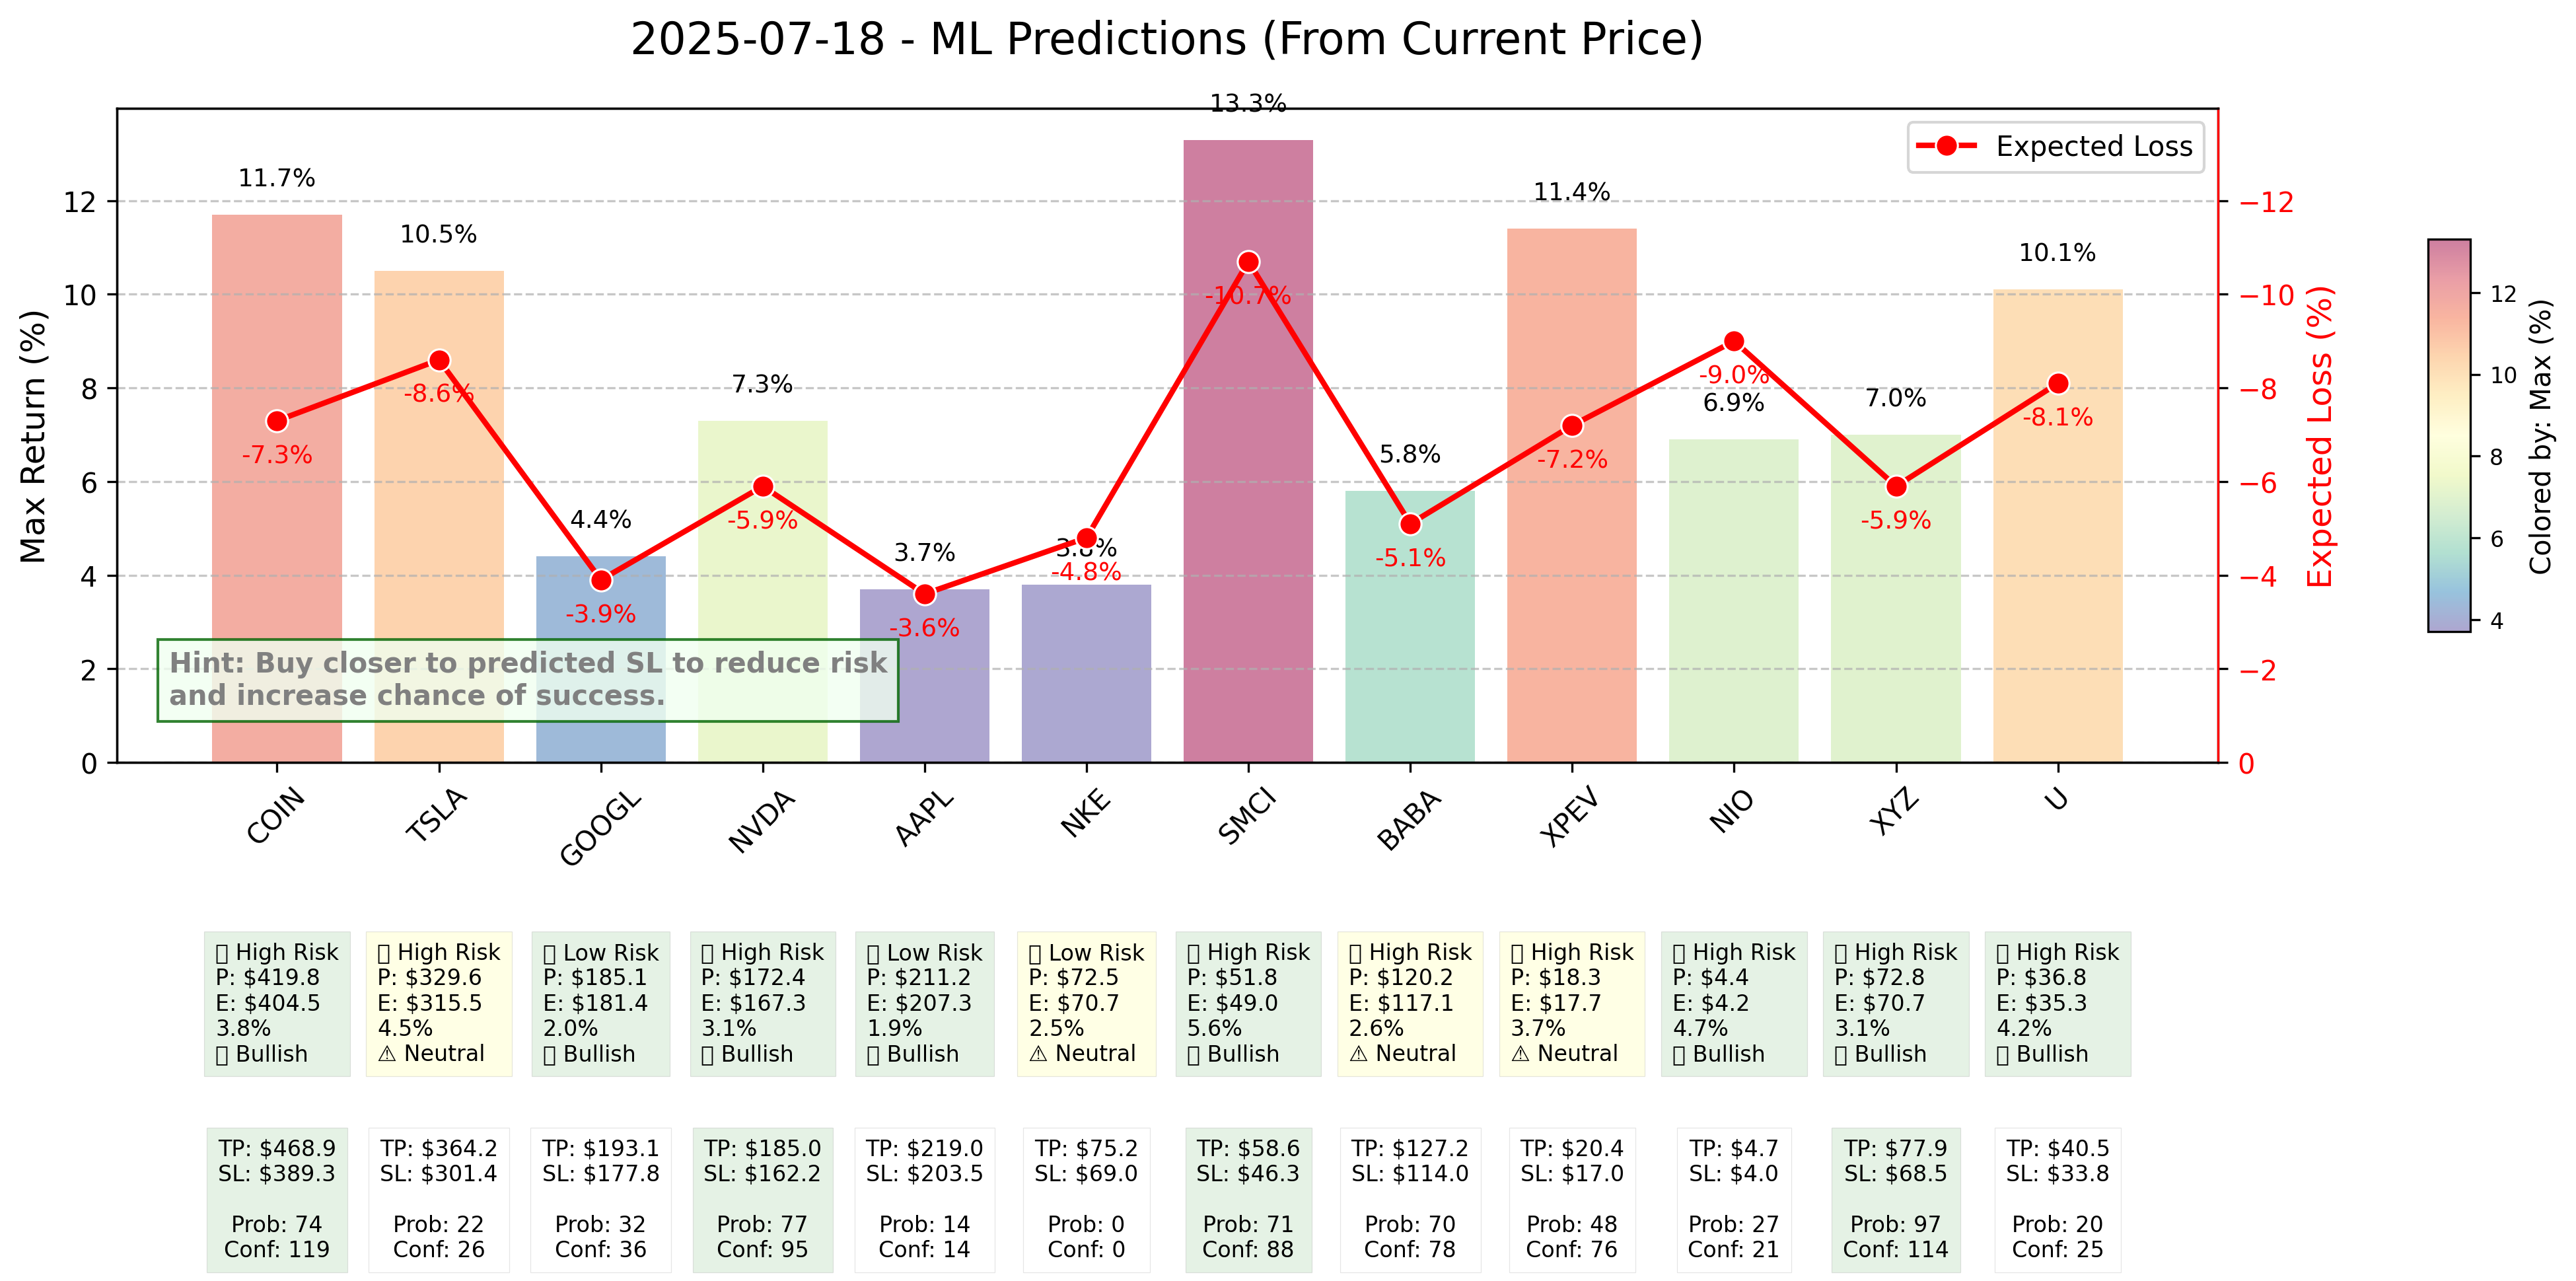

In [22]:
# ✅ PLOT PREDICTIONS

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_plot = df_results
#df_plot = df_plot.sort_values(by="Max (%)", ascending=False)
max_vals = df_plot["Max (%)"].to_numpy()
norm = mcolors.Normalize(vmin=min(max_vals), vmax=max(max_vals))
cmap = cm.Spectral_r #Inverse of spectral
custom_colors = cmap(norm(max_values))

fig, ax1 = plt.subplots(figsize=(12, 6), zorder=1, dpi=300)
cax = inset_axes(ax1, width="2%", height="60%", loc='center right',
                 bbox_to_anchor=(0.12, 0., 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)

# Main bar plot
ax1.bar(df_plot["Ticker"], max_values, color=custom_colors, alpha = 0.5)
ax1.set_ylabel('Max Return (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add colorbar at the right of the plot
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical', label="Colored by: Max (%)", alpha = 0.5)
cbar.ax.tick_params(labelsize=8)

# Secondary axis for loss line
ax2 = ax1.twinx()
sns.lineplot(x="Ticker", y="Loss (%)", data=df_plot, color='red', marker='o',
             ax=ax2, linewidth=2, markersize=8, label='Expected Loss')
ax2.set_ylabel('Expected Loss (%)', fontsize=12, color='red')

combined_min = min(ax1.get_ylim()[0], -ax2.get_ylim()[1])
combined_max = max(ax1.get_ylim()[1], -ax2.get_ylim()[0])
ax1.set_ylim(combined_min, combined_max)
ax2.set_ylim(-combined_max, -combined_min)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()

# --- ANNOTATIONS ALIGNED BELOW X-TICK LABELS ---
x_ticks = ax1.get_xticks()
for i, (_, row) in enumerate(df_plot.iterrows()):
    # Color assignment for signal types
    fcolor = (
        'green' if row.Signal == "✅ Bullish"
        else 'red' if row.Signal == "🔻 Bearish"
        else 'yellow'
    )
    ProbColor = 'green' if (row.Signal == "✅ Bullish" and row.Confidence > 40) else 'white'

    # Top annotations (unchanged)
    ax1.text(i, row["Max (%)"] + 0.5, f'{row["Max (%)"]:.1f}%',
             ha='center', va='bottom', fontsize=9)
    ax2.text(i, row["Loss (%)"] + 0.5, f'{row["Loss (%)"]:.1f}%',
             ha='center', va='top', color='red', fontsize=9)

    # Bottom annotations: align with x-tick, just below tick label
    x_tick = x_ticks[i]
    y_offset1 = -0.275  # Adjust as needed for your plot
    y_offset2 = -0.575  # Stagger if two boxes per tick

    ax1.text(
        x_tick, y_offset1,
        f'{row["Risk"]}\nP: ${row["Price"]:.1f}\nE: ${row["Entry"]:.1f}\n{row["Entry%"]:.1f}%\n{row["Signal"]}',
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor=fcolor, alpha=0.1, linewidth=0.3),
        transform=ax1.get_xaxis_transform(),
        multialignment='left',
        clip_on=False
    )

    ax1.text(
        x_tick, y_offset2,
        f'TP: ${row["TP"]:.1f}\nSL: ${row["SL"]:.1f}\n\nProb: {row["Hit_Prob"]:.0f}\nConf: {row["Confidence"]:.0f}',
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor=ProbColor, alpha=0.1, linewidth=0.3),
        transform=ax1.get_xaxis_transform(),
        clip_on=False
    )

# Strategic hint box
textbox = AnchoredText(
    "Hint: Buy closer to predicted SL to reduce risk\nand increase chance of success.",
    loc='lower left',
    frameon=True,
    borderpad=1.5,
    prop=dict(size=10, color='gray', weight='bold')
)
ax1.add_artist(textbox)
textbox.set_clip_on(True)
textbox.set_in_layout(True)
textbox.set_zorder(100)
textbox.patch.set_facecolor('honeydew')
textbox.patch.set_edgecolor('darkgreen')
textbox.patch.set_alpha(0.8)

# Space management
plt.title(f'{today} - ML Predictions (From Current Price)', fontsize=16, pad=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # Increase if needed for annotation visibility

# Save and show
fname = f'{today}_ML_PNL_MultiStocks.png'
fpath = os.path.join(path, fname)
plt.savefig(fpath, bbox_inches='tight')
plt.show()


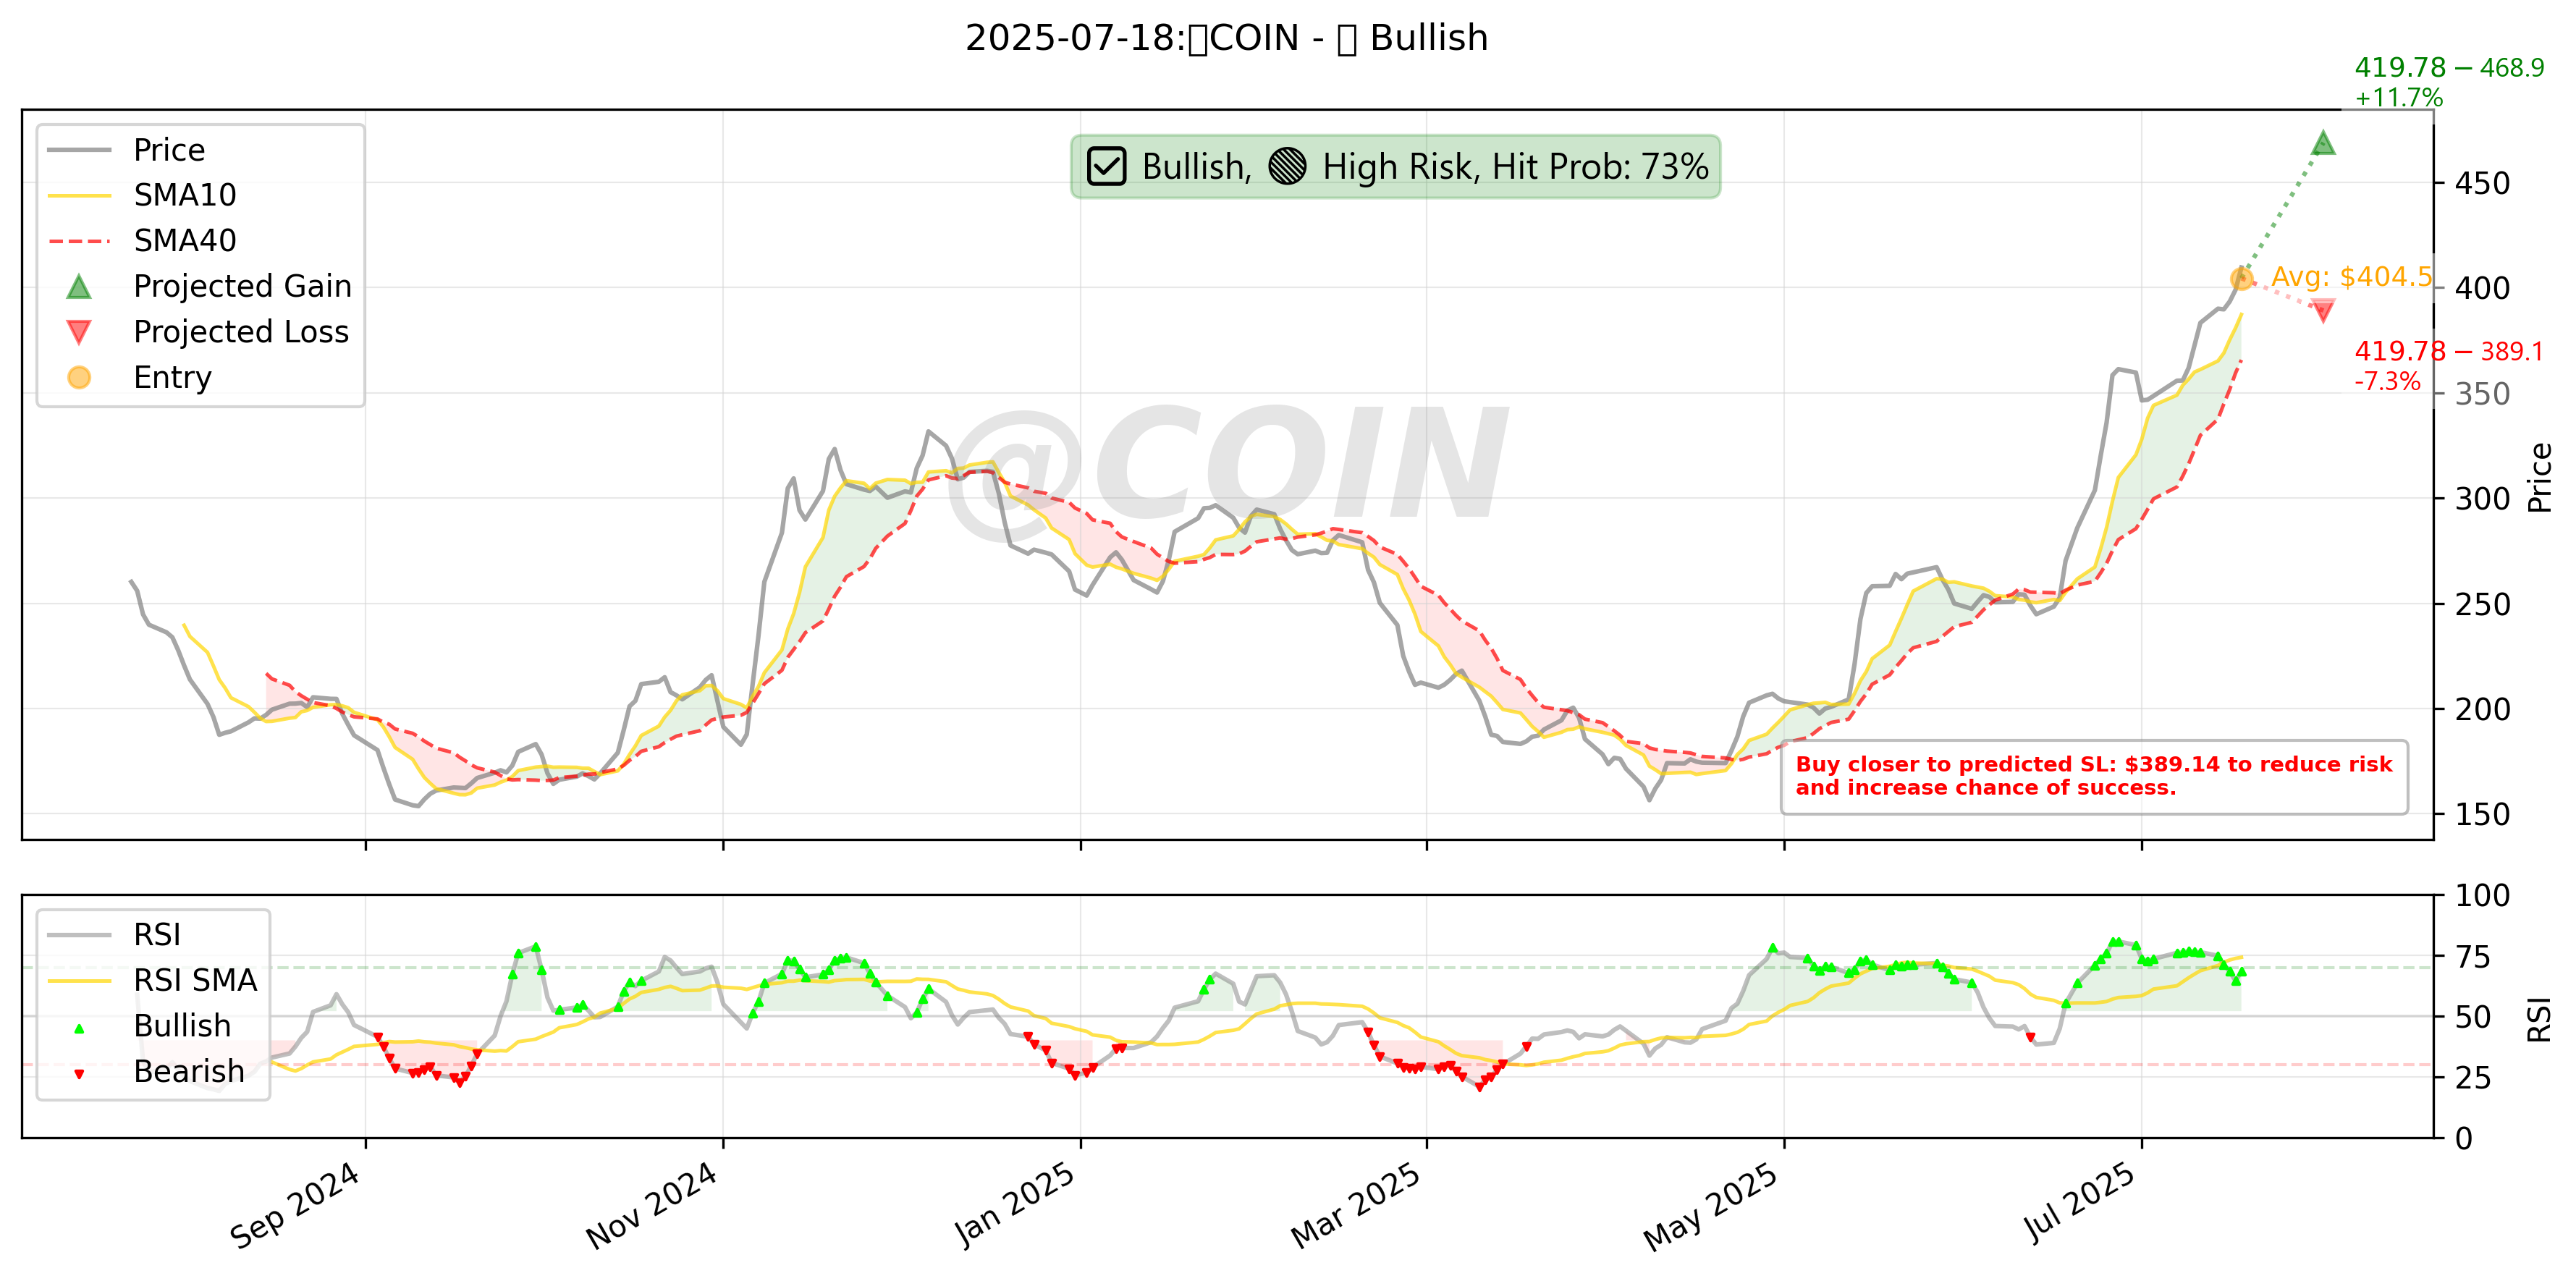

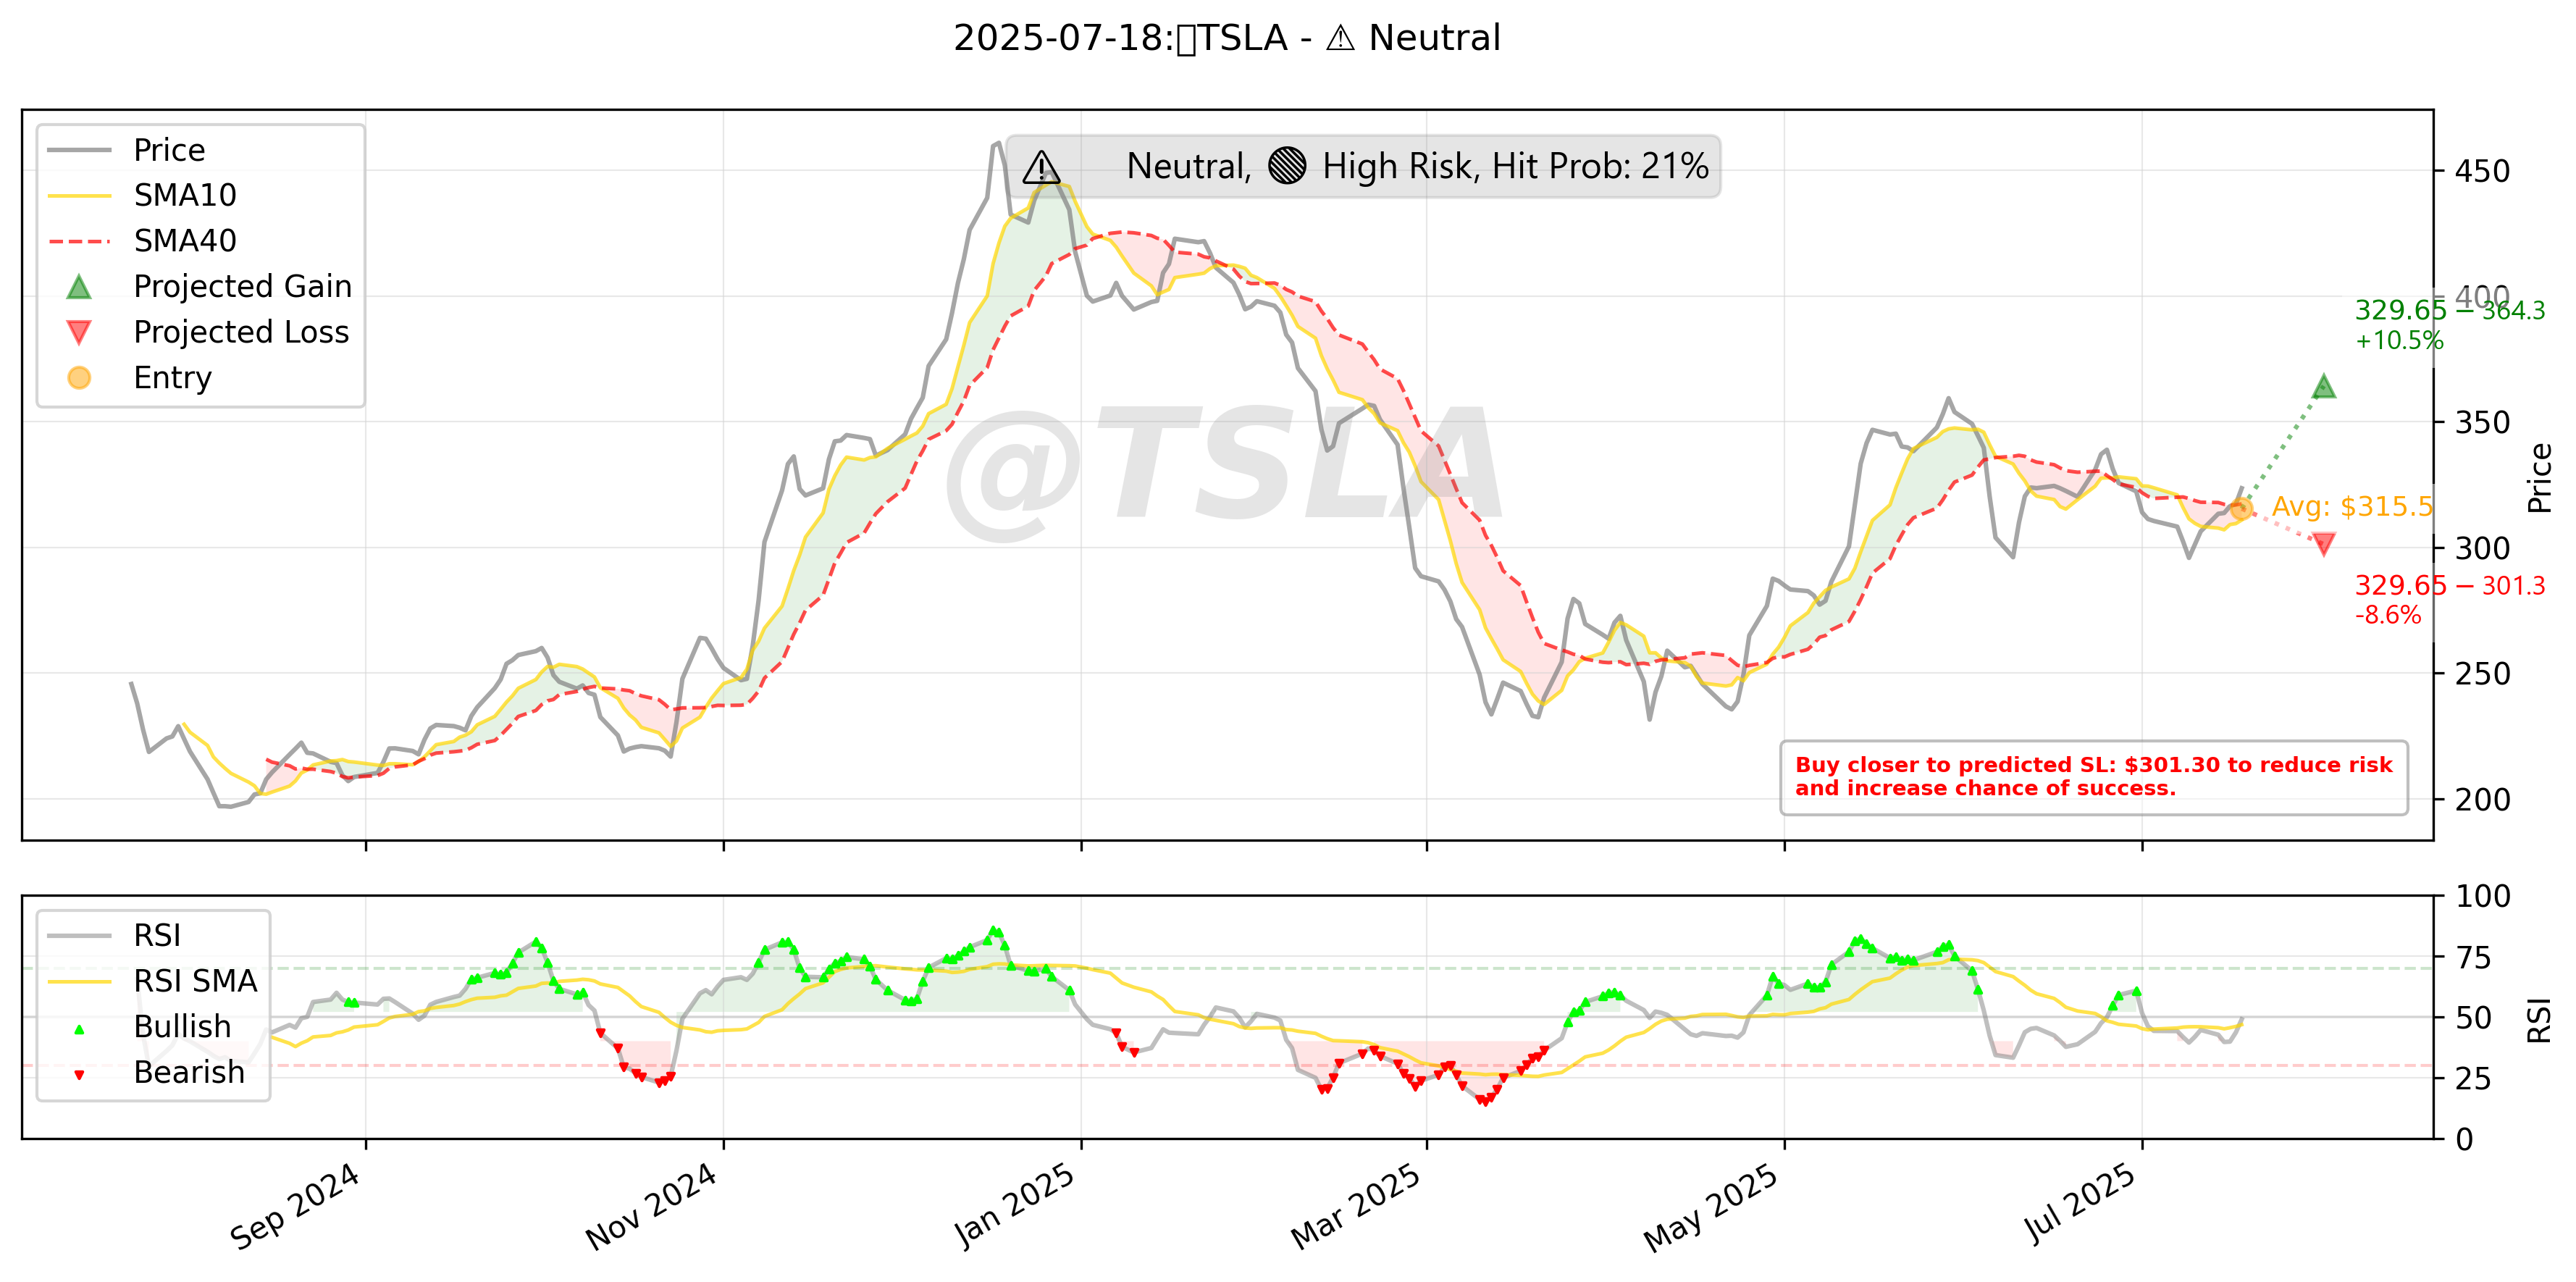

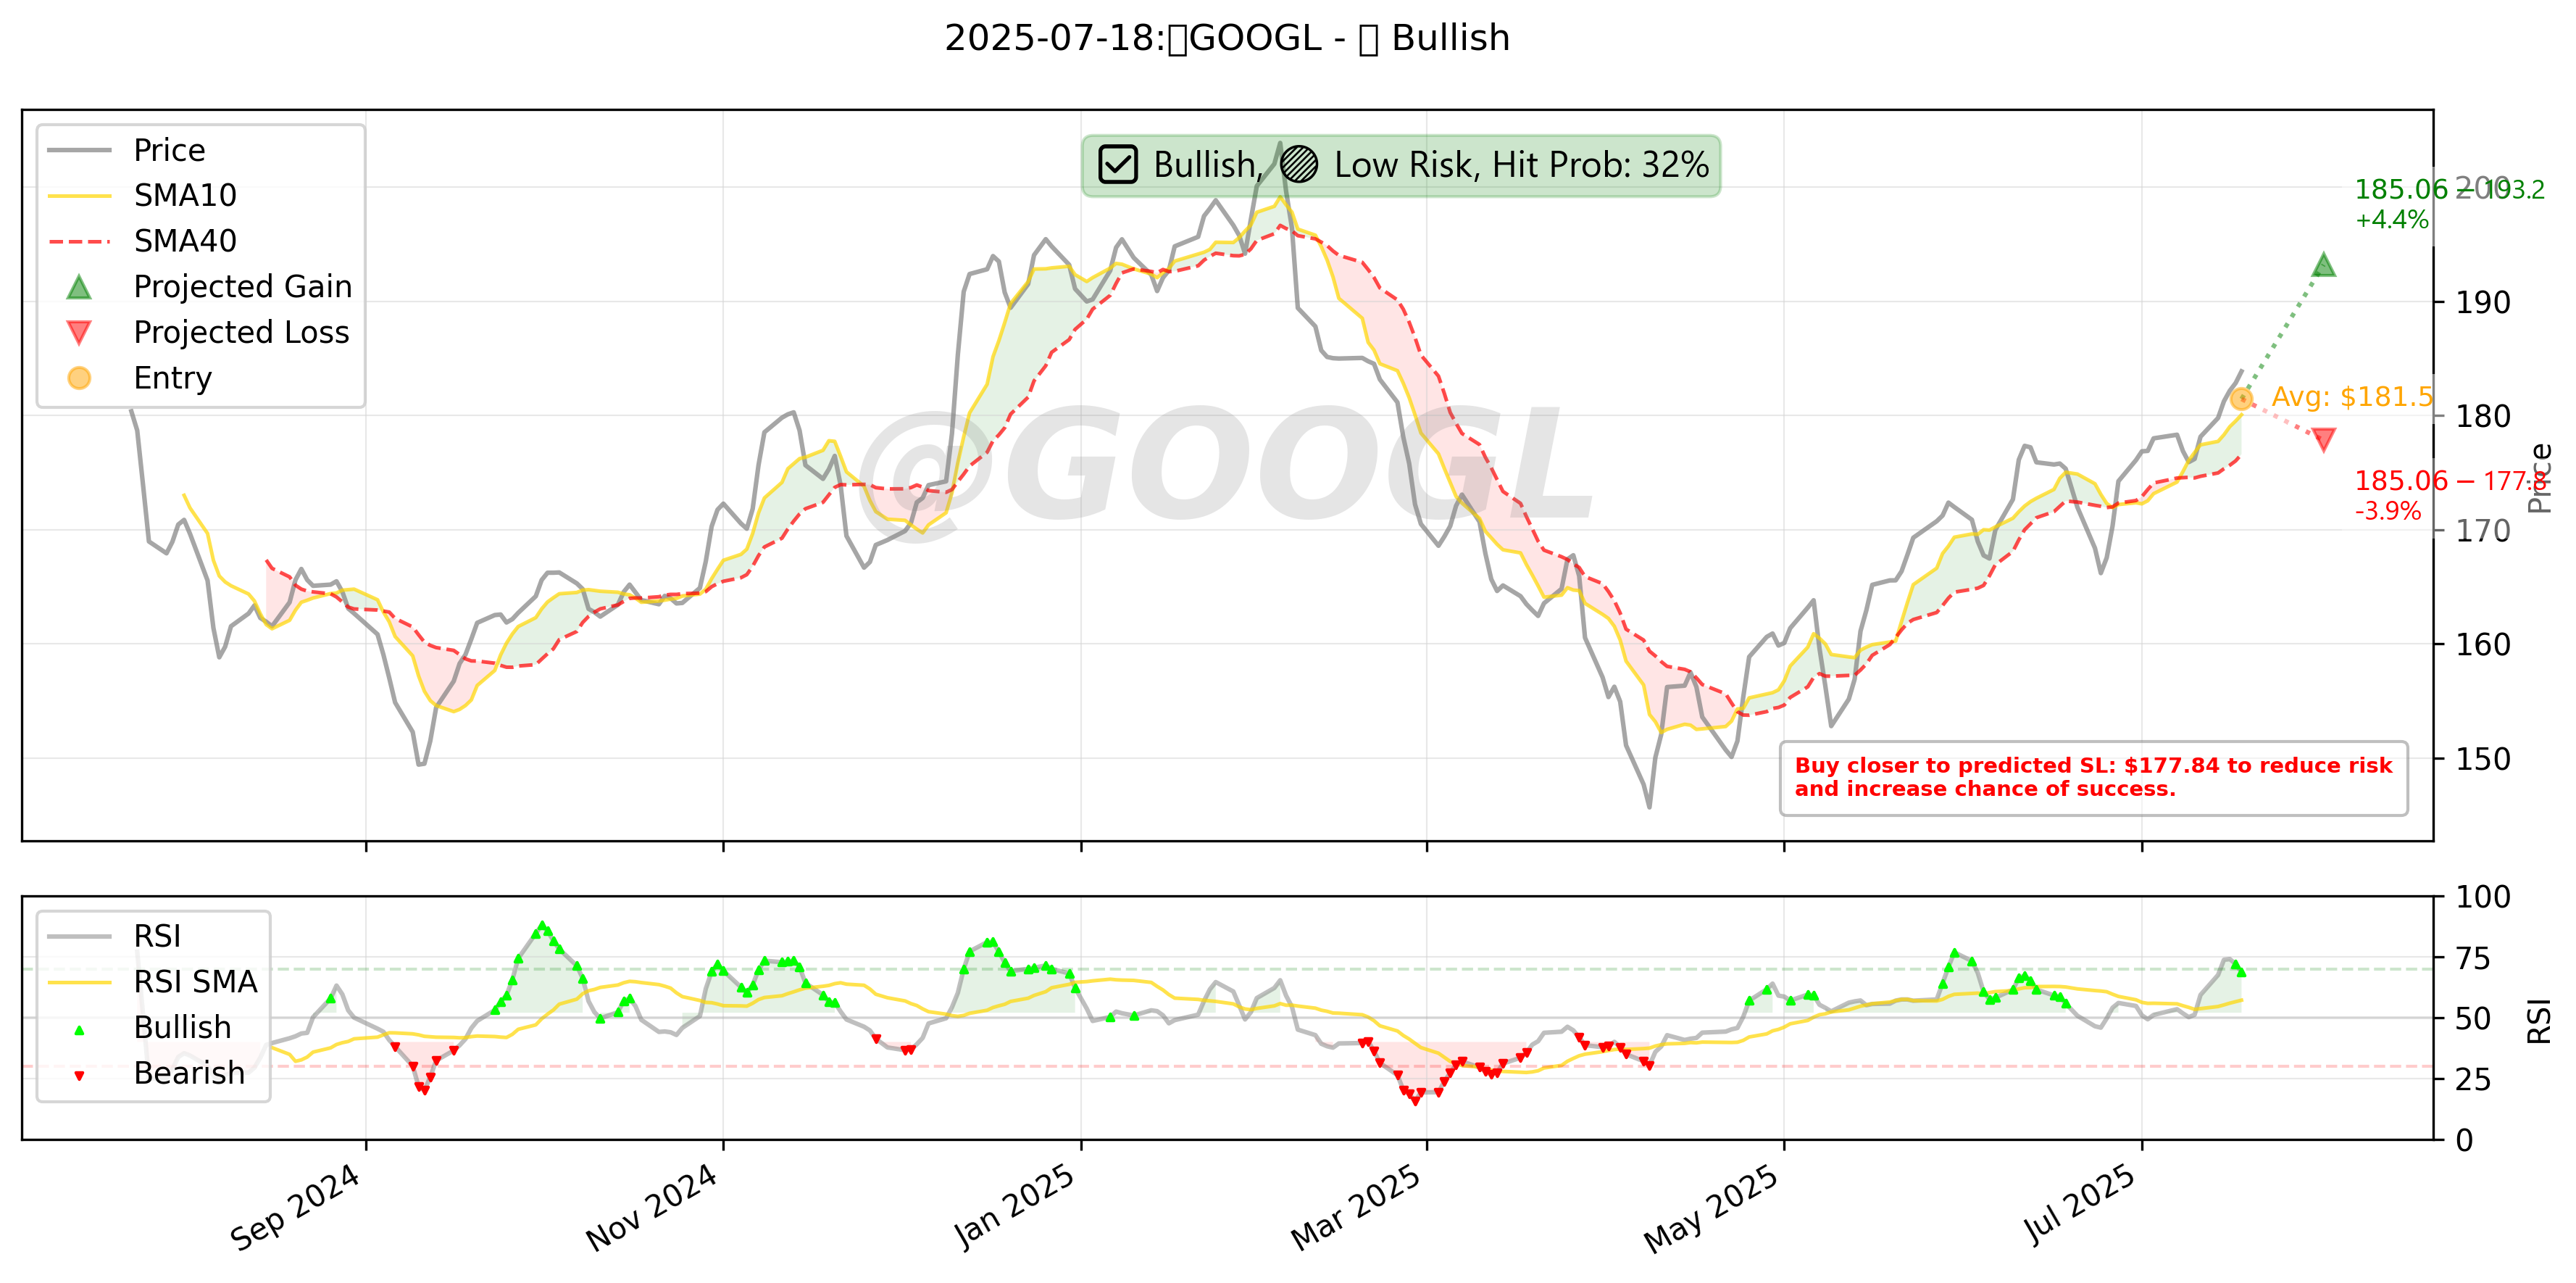

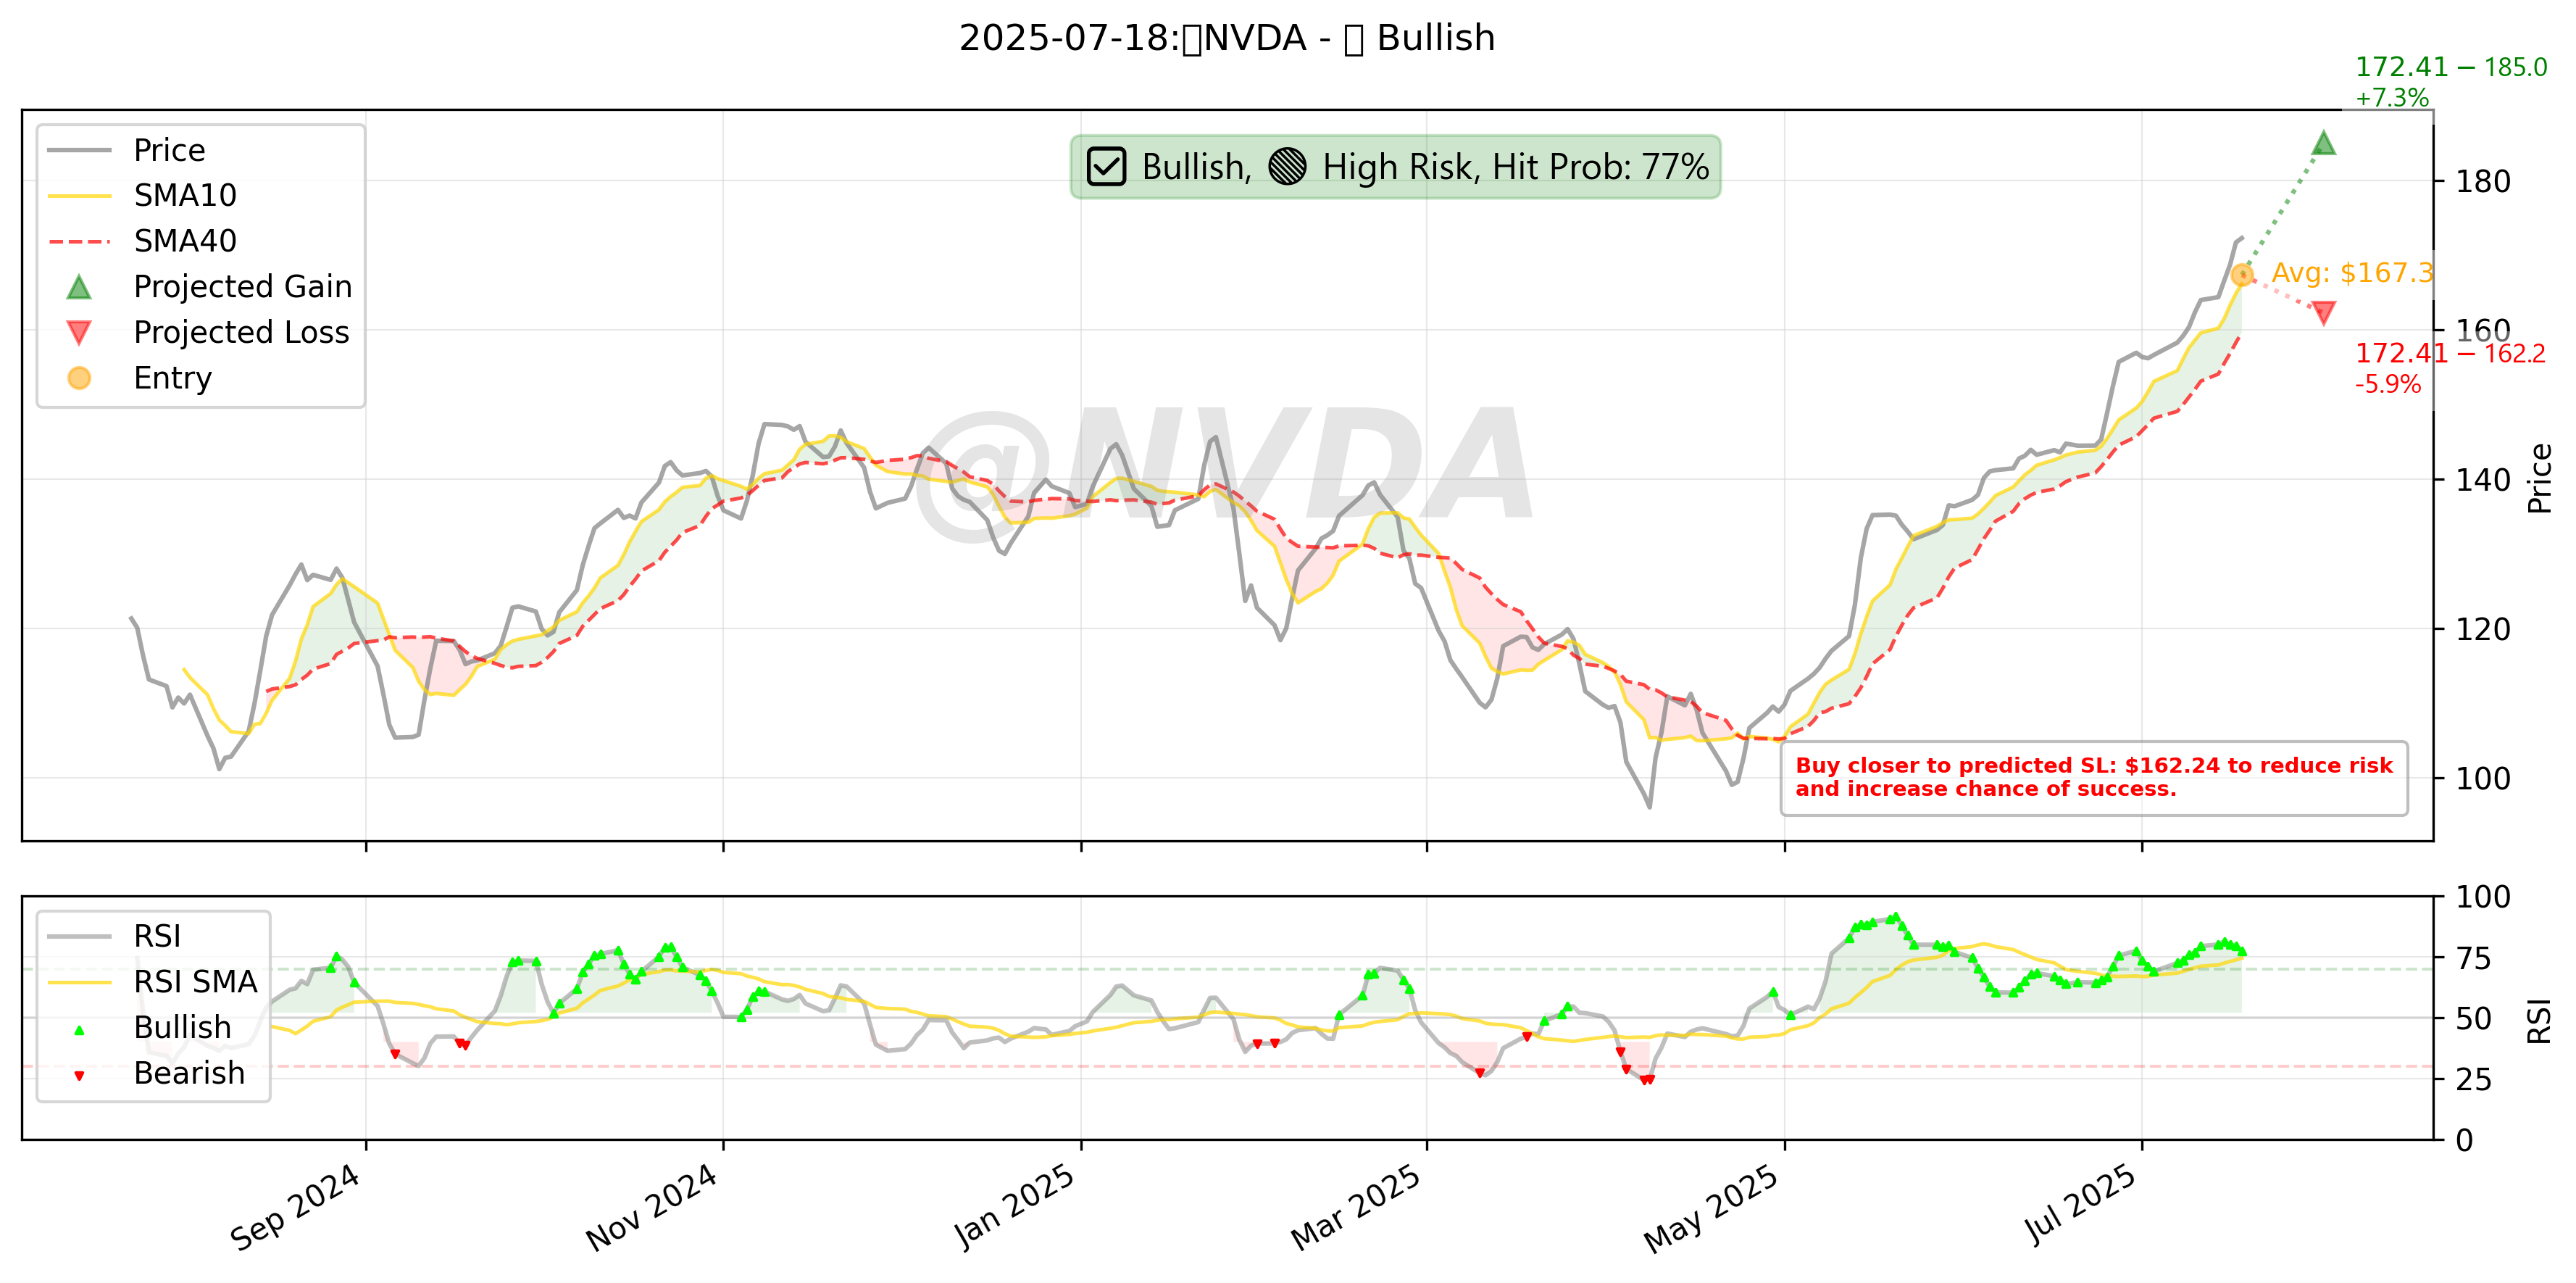

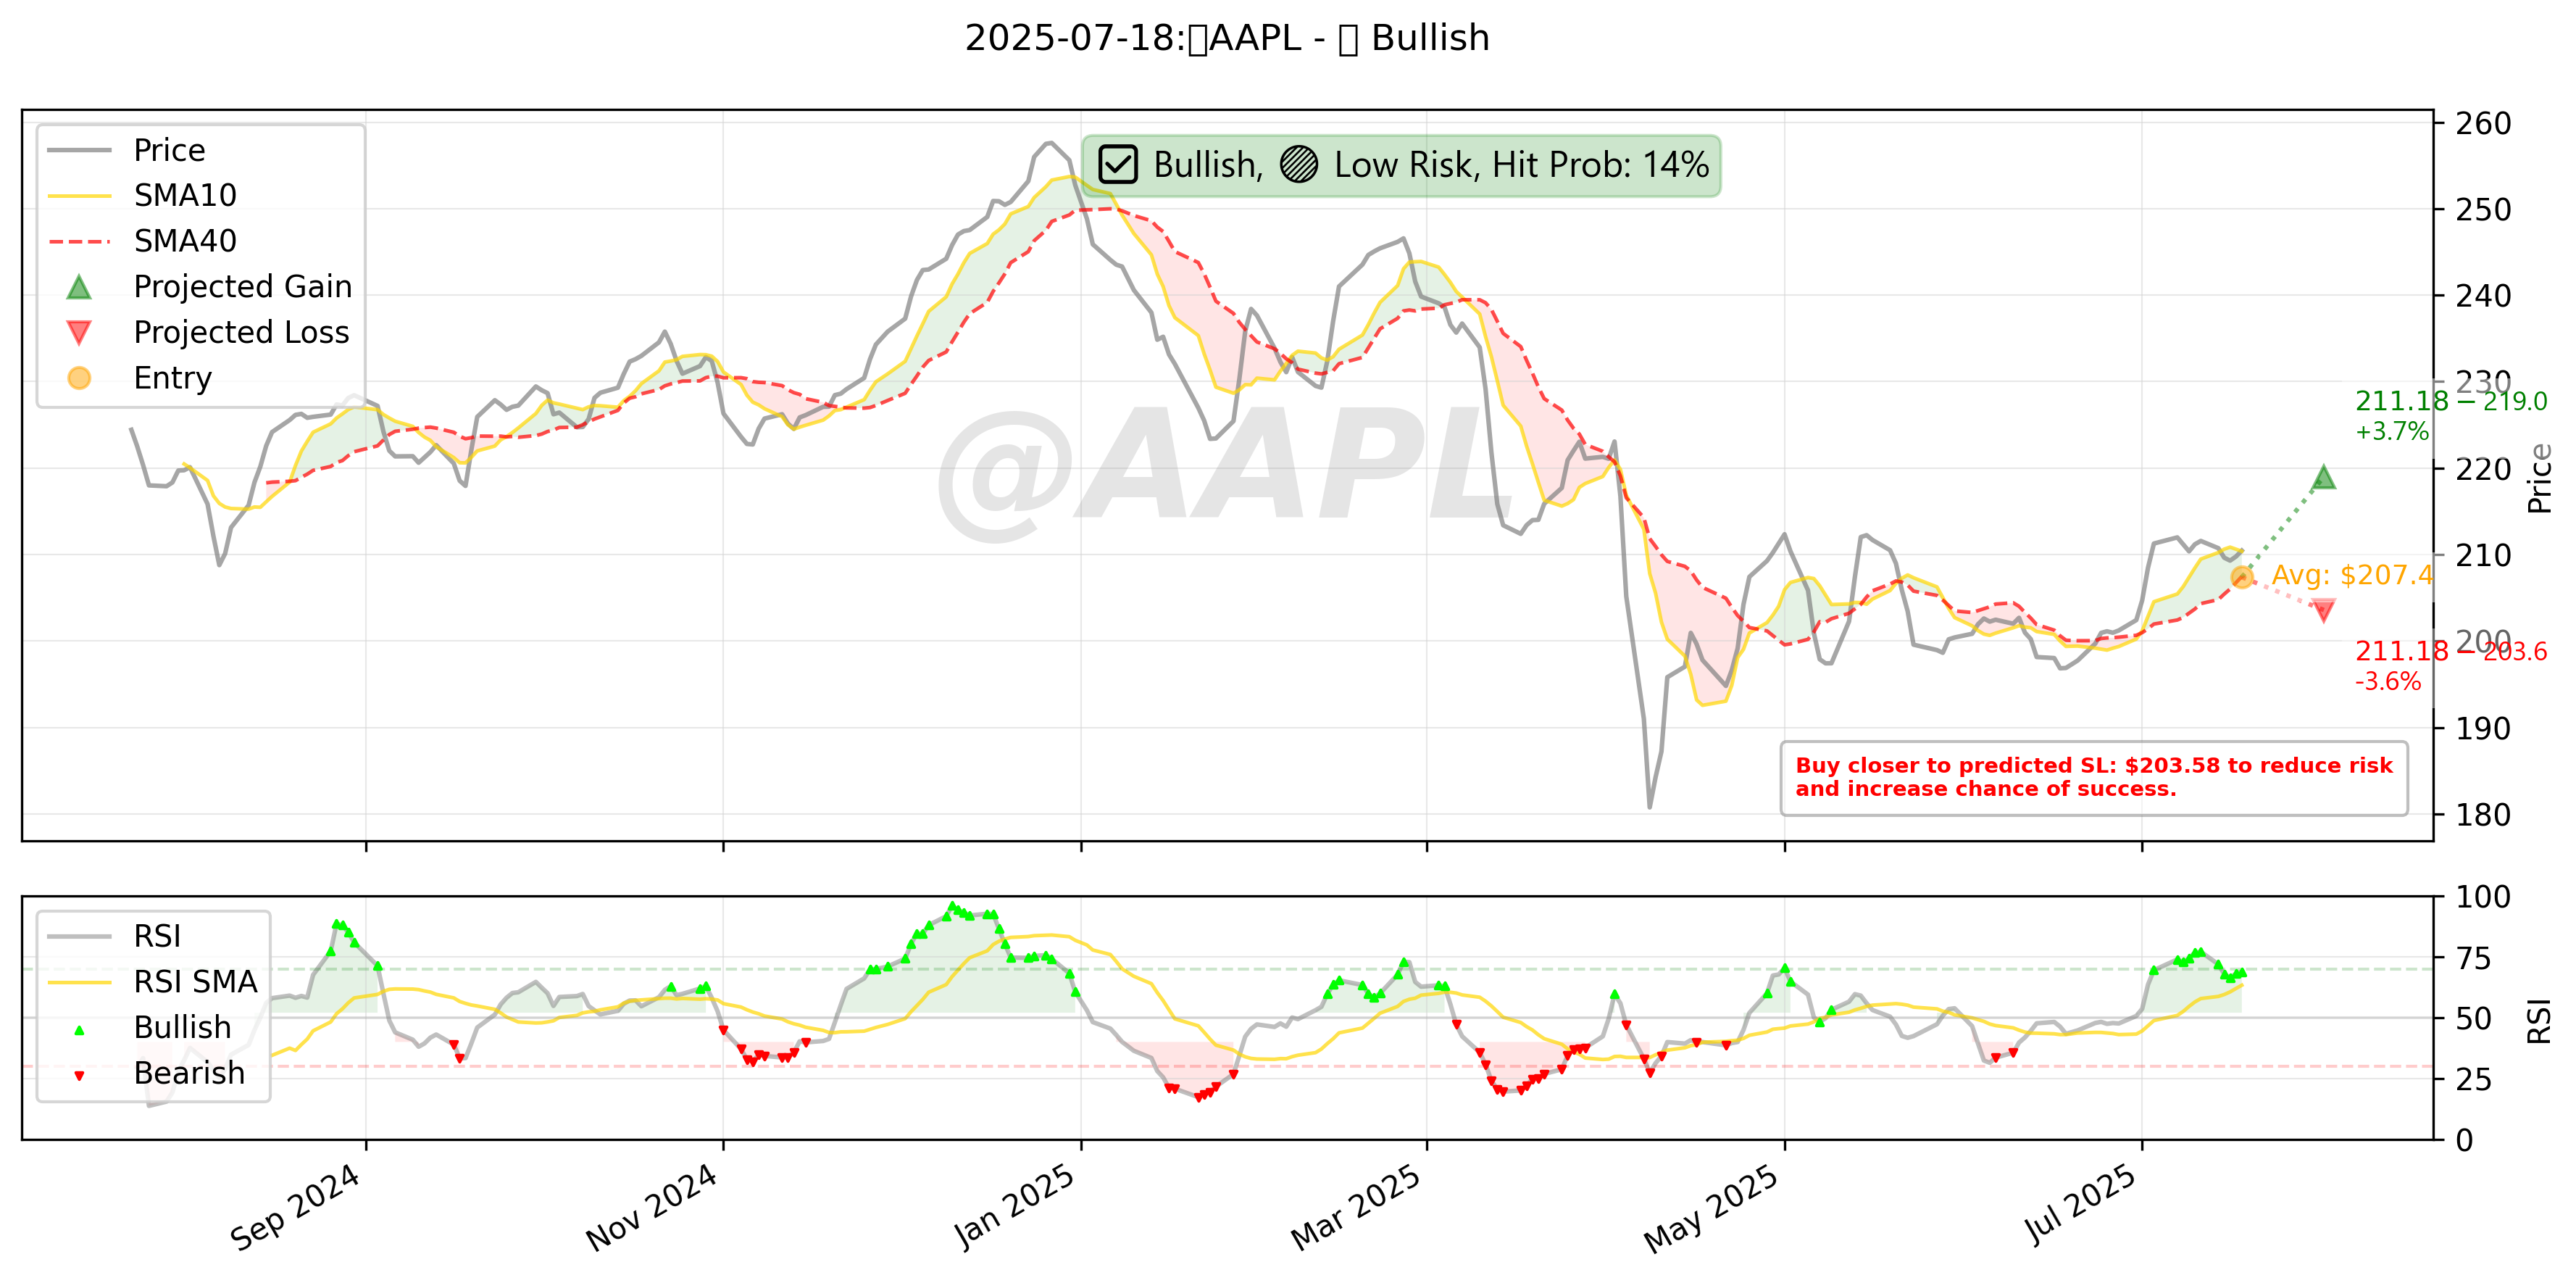

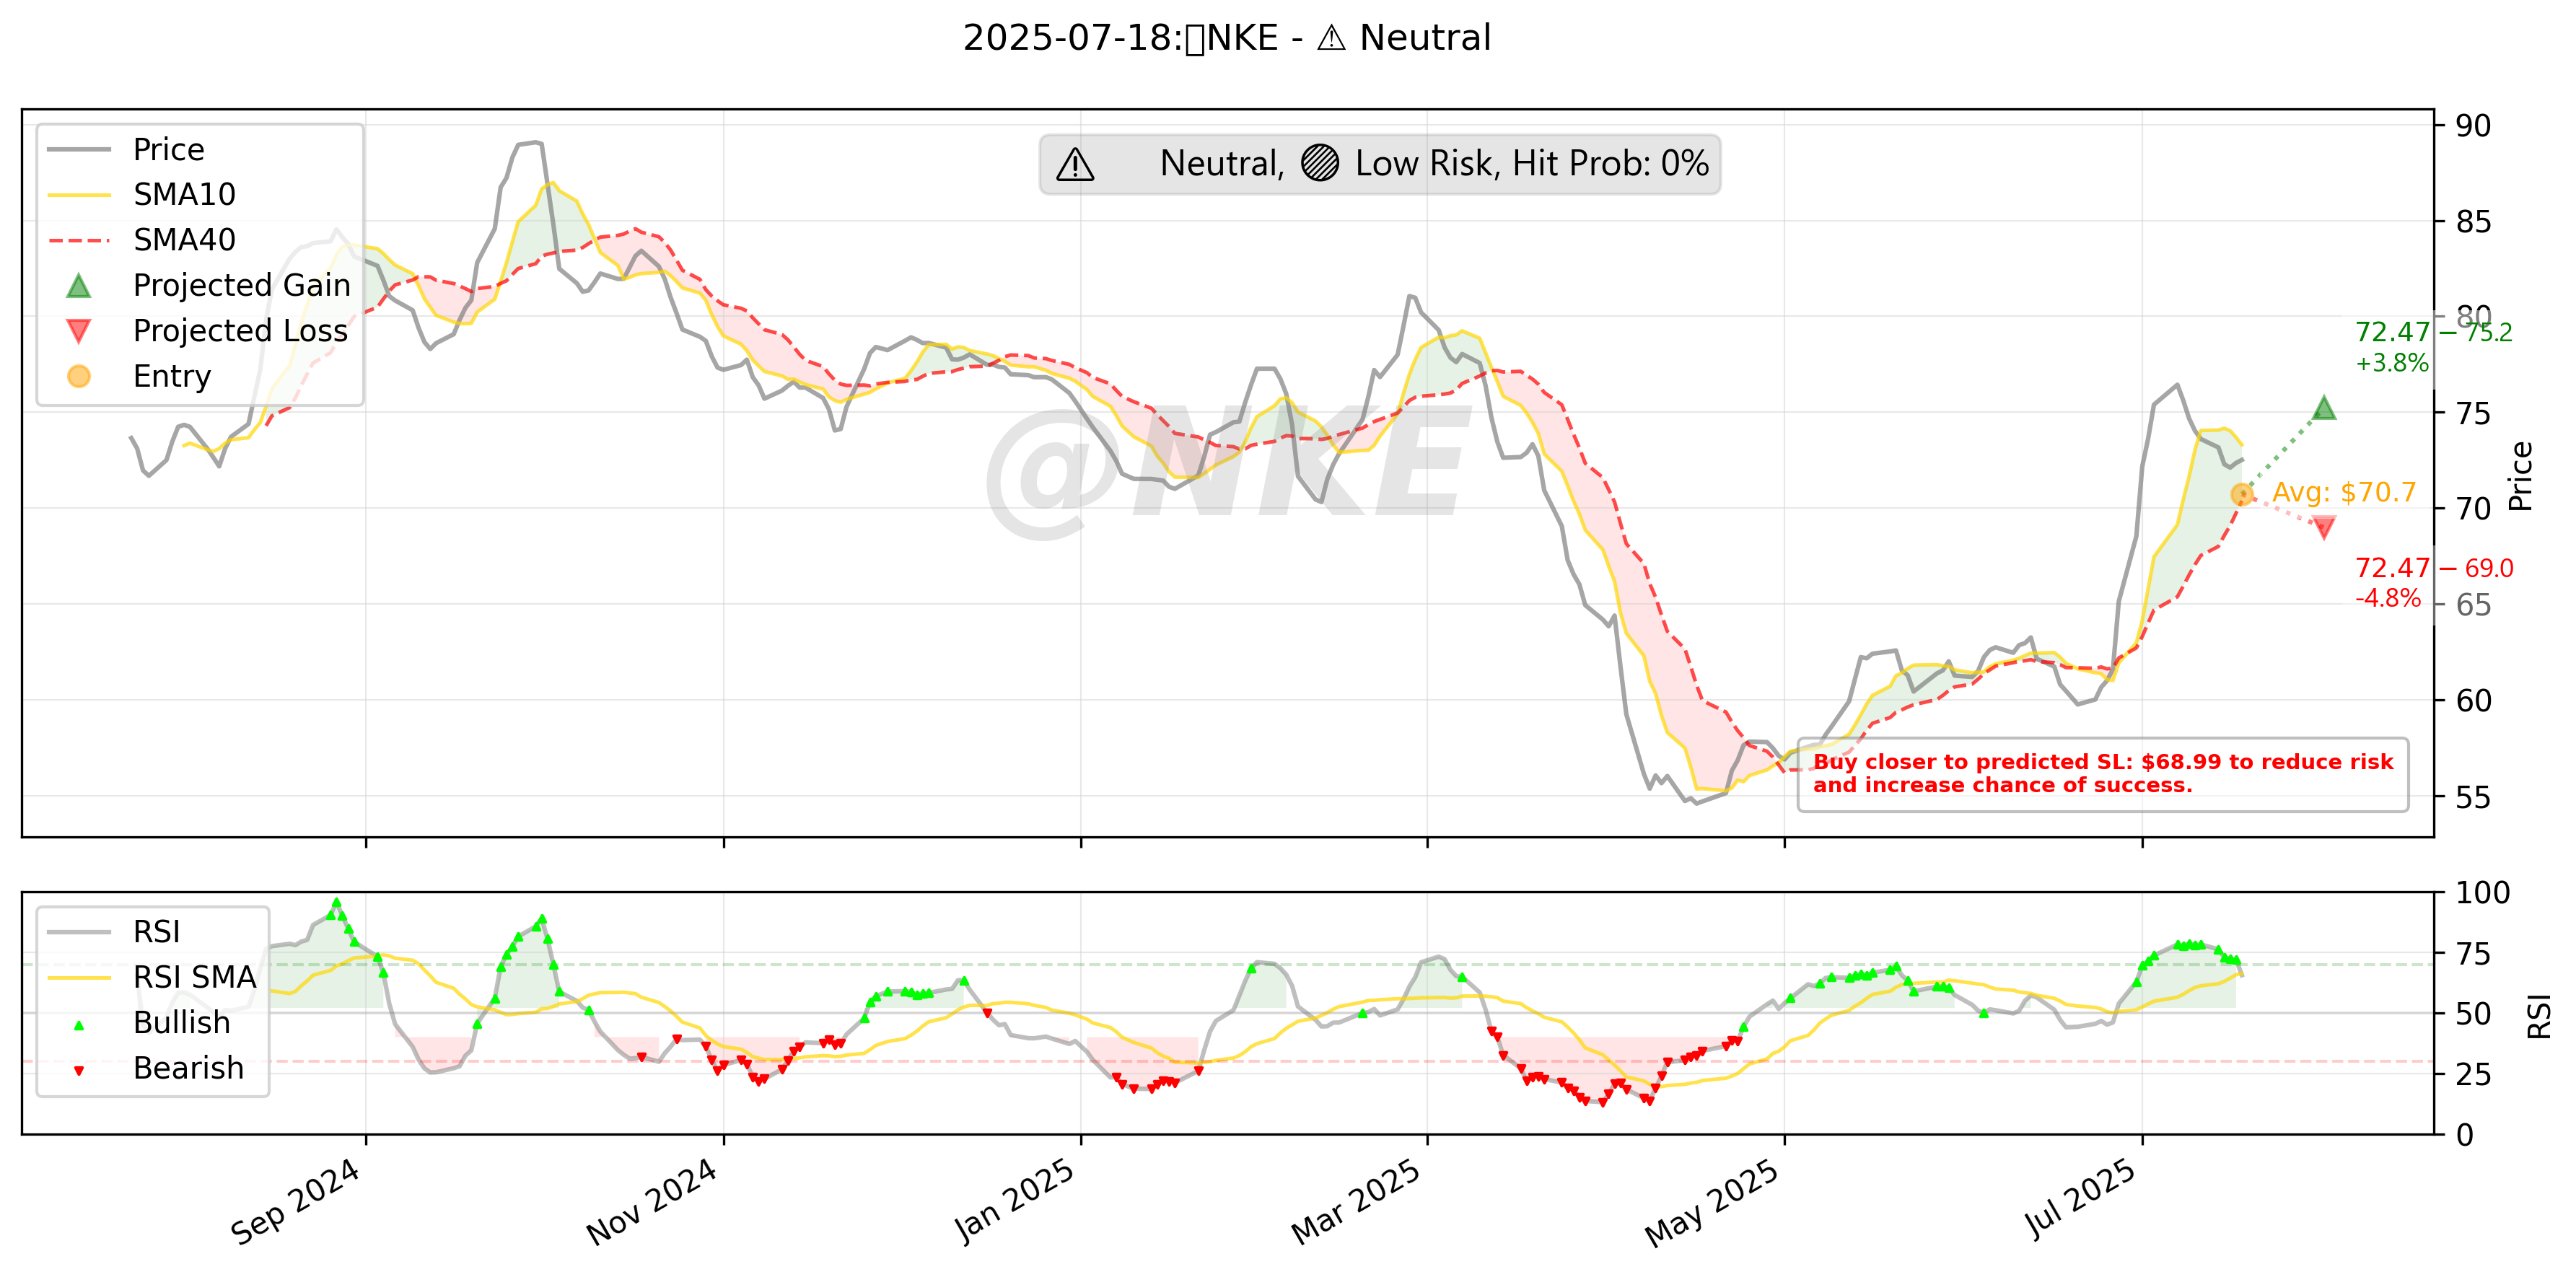

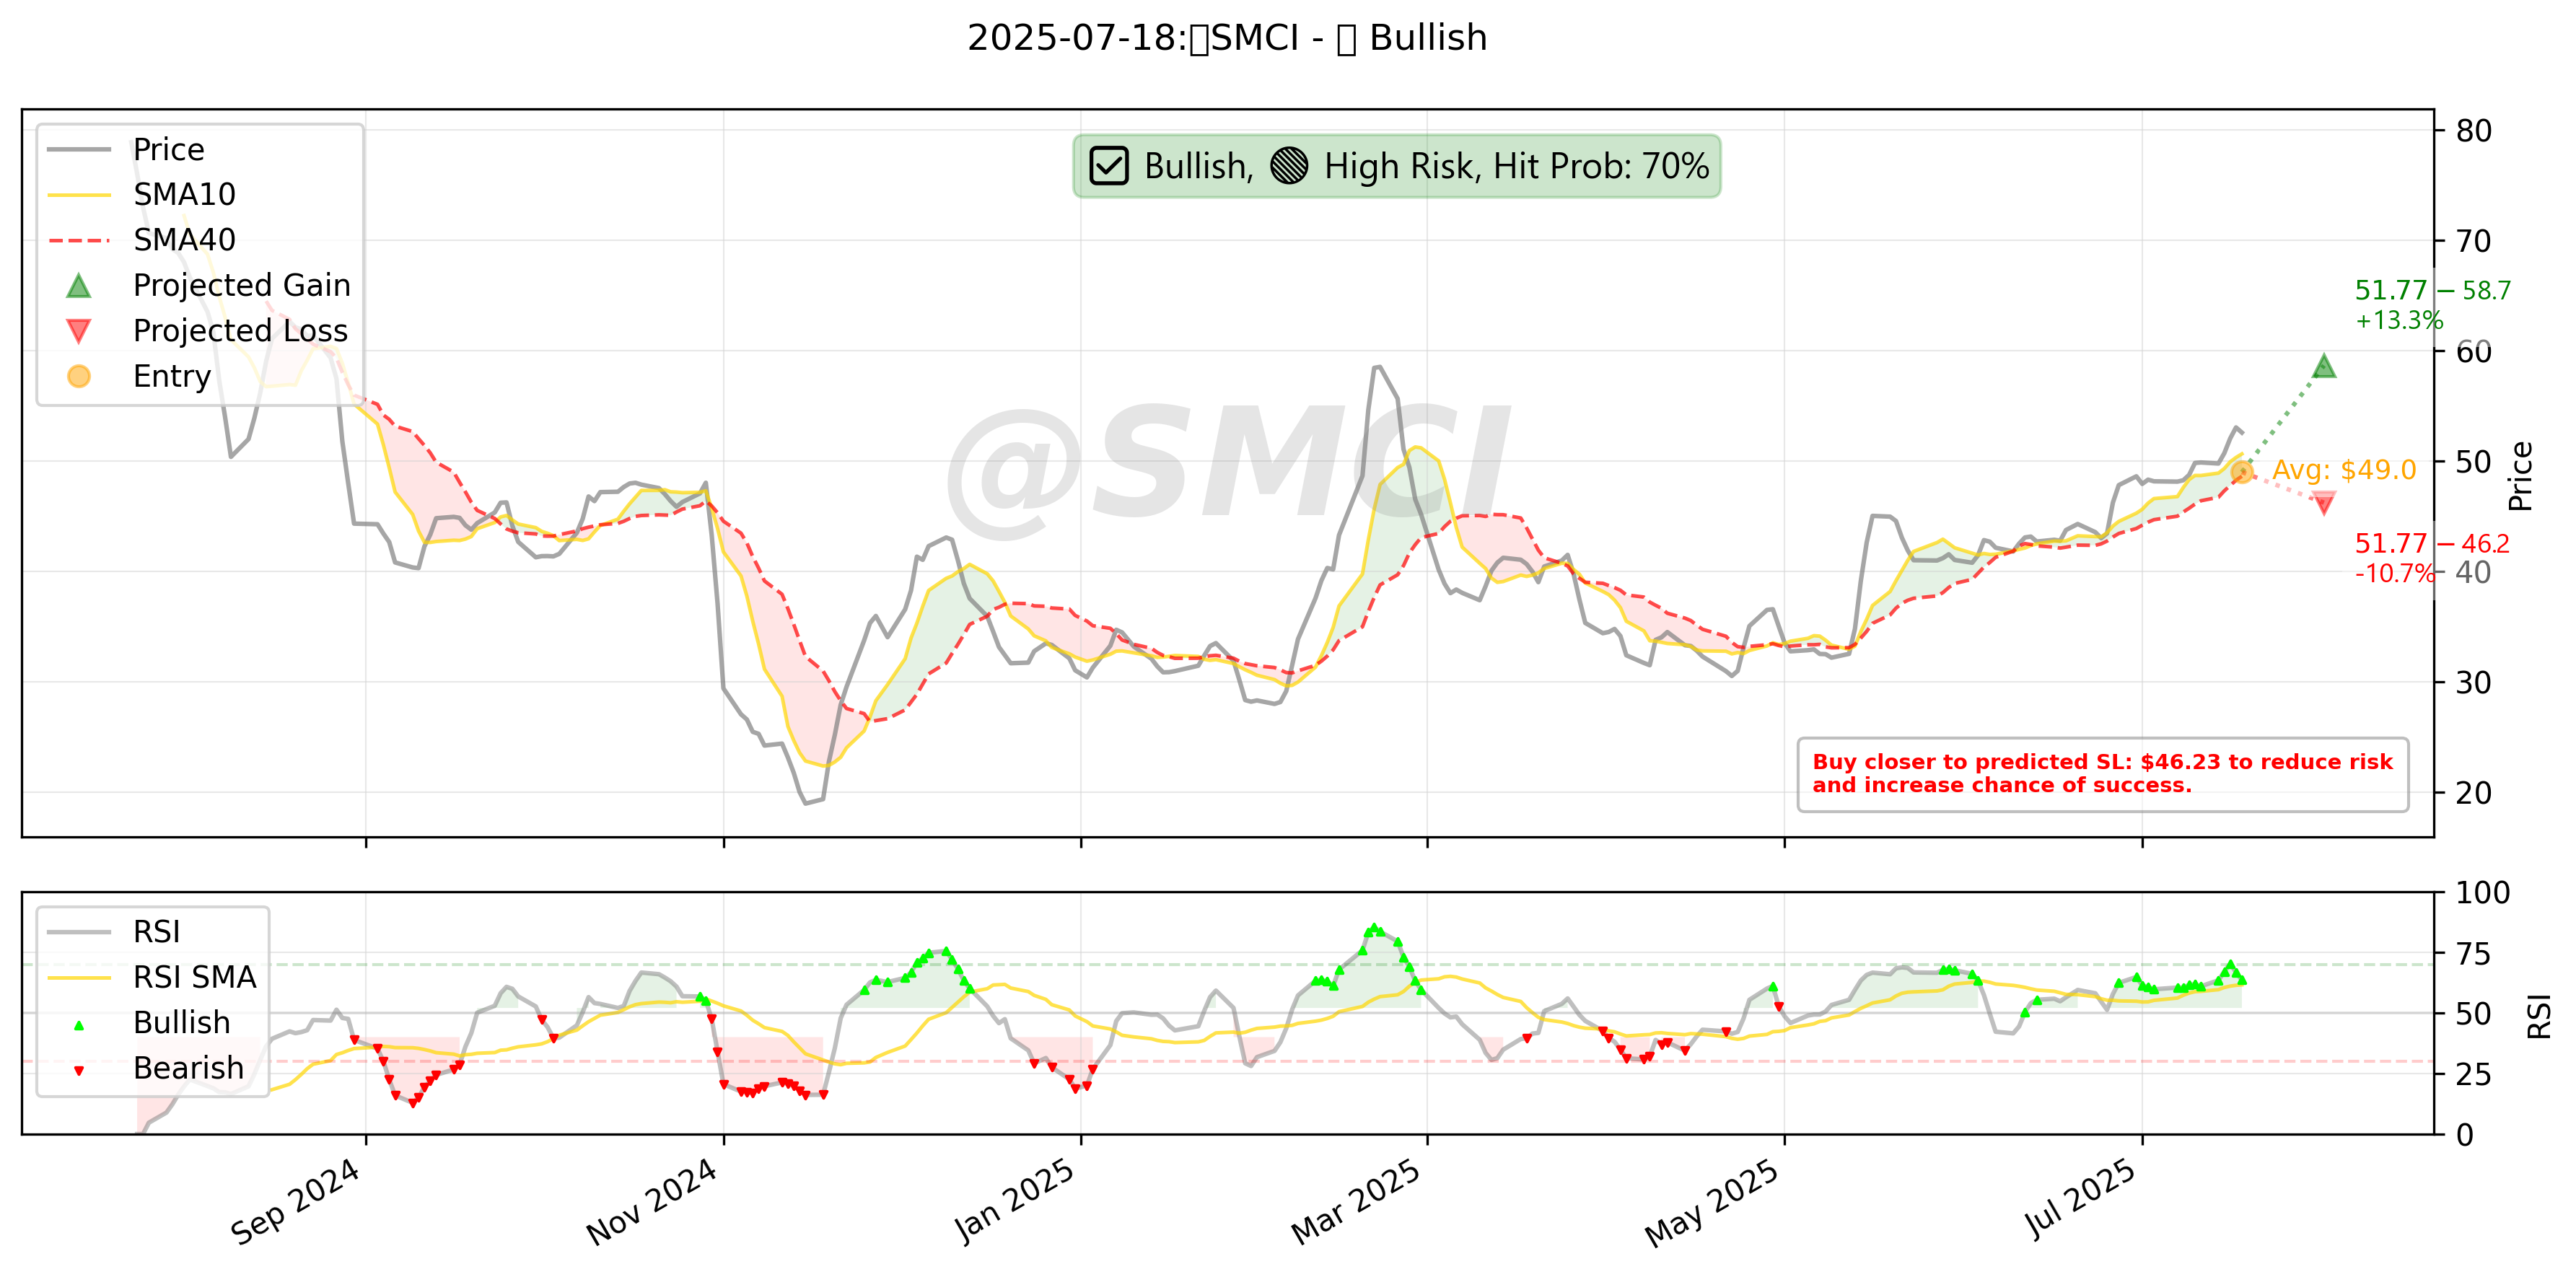

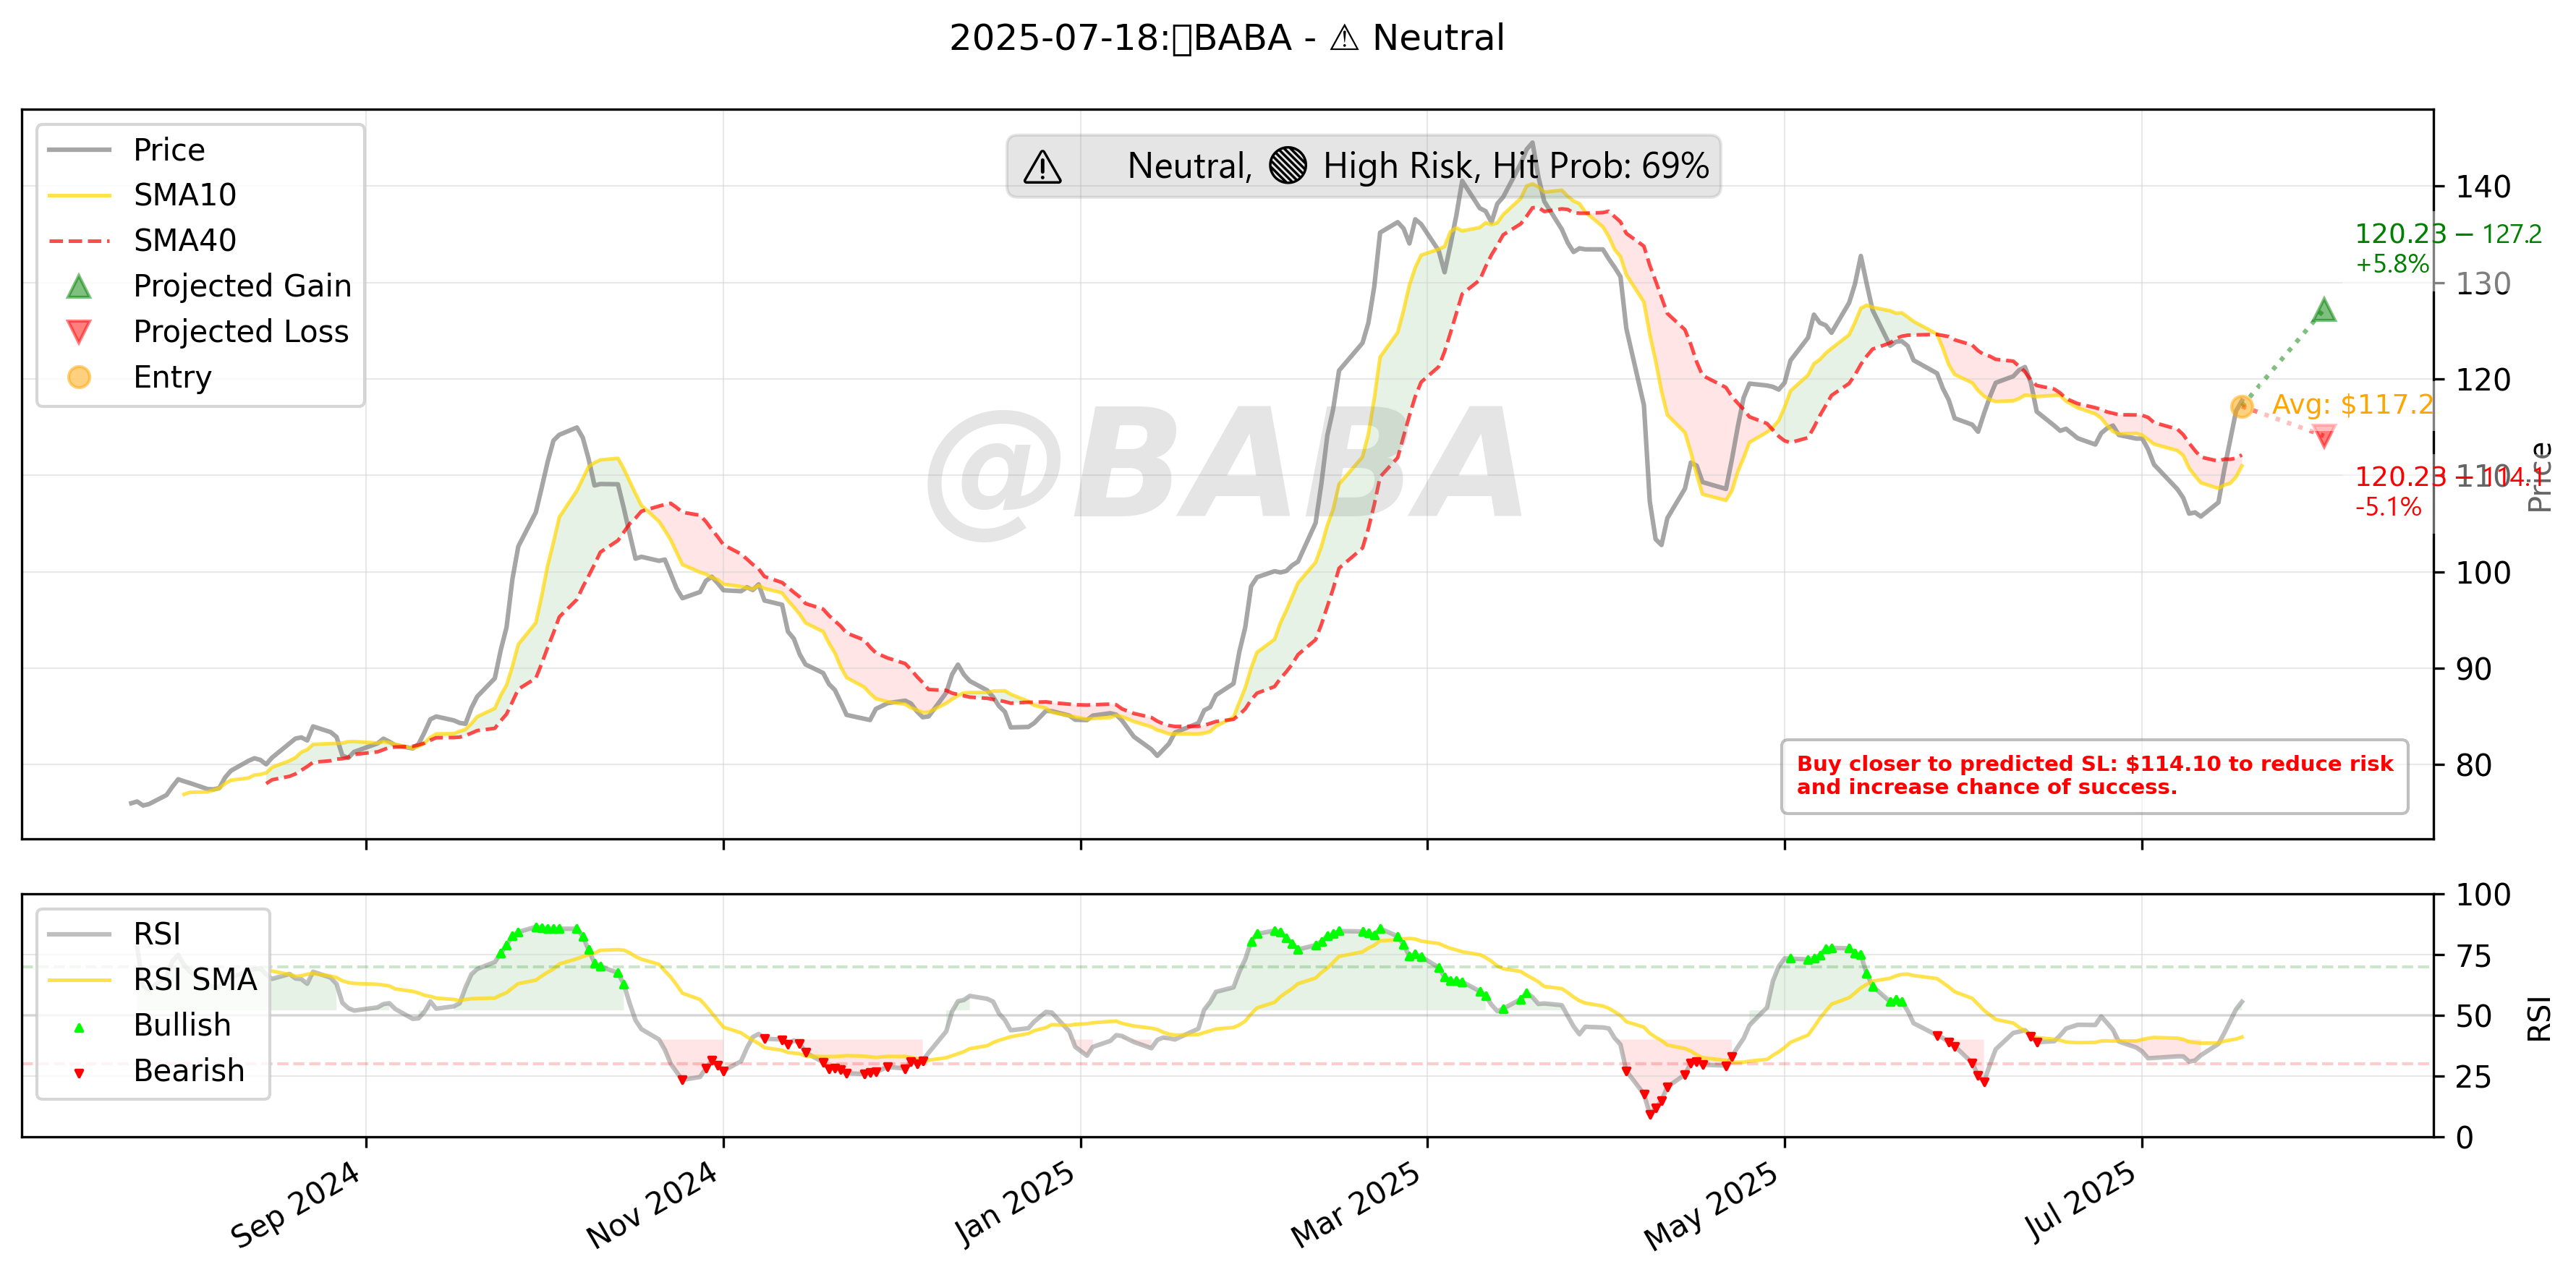

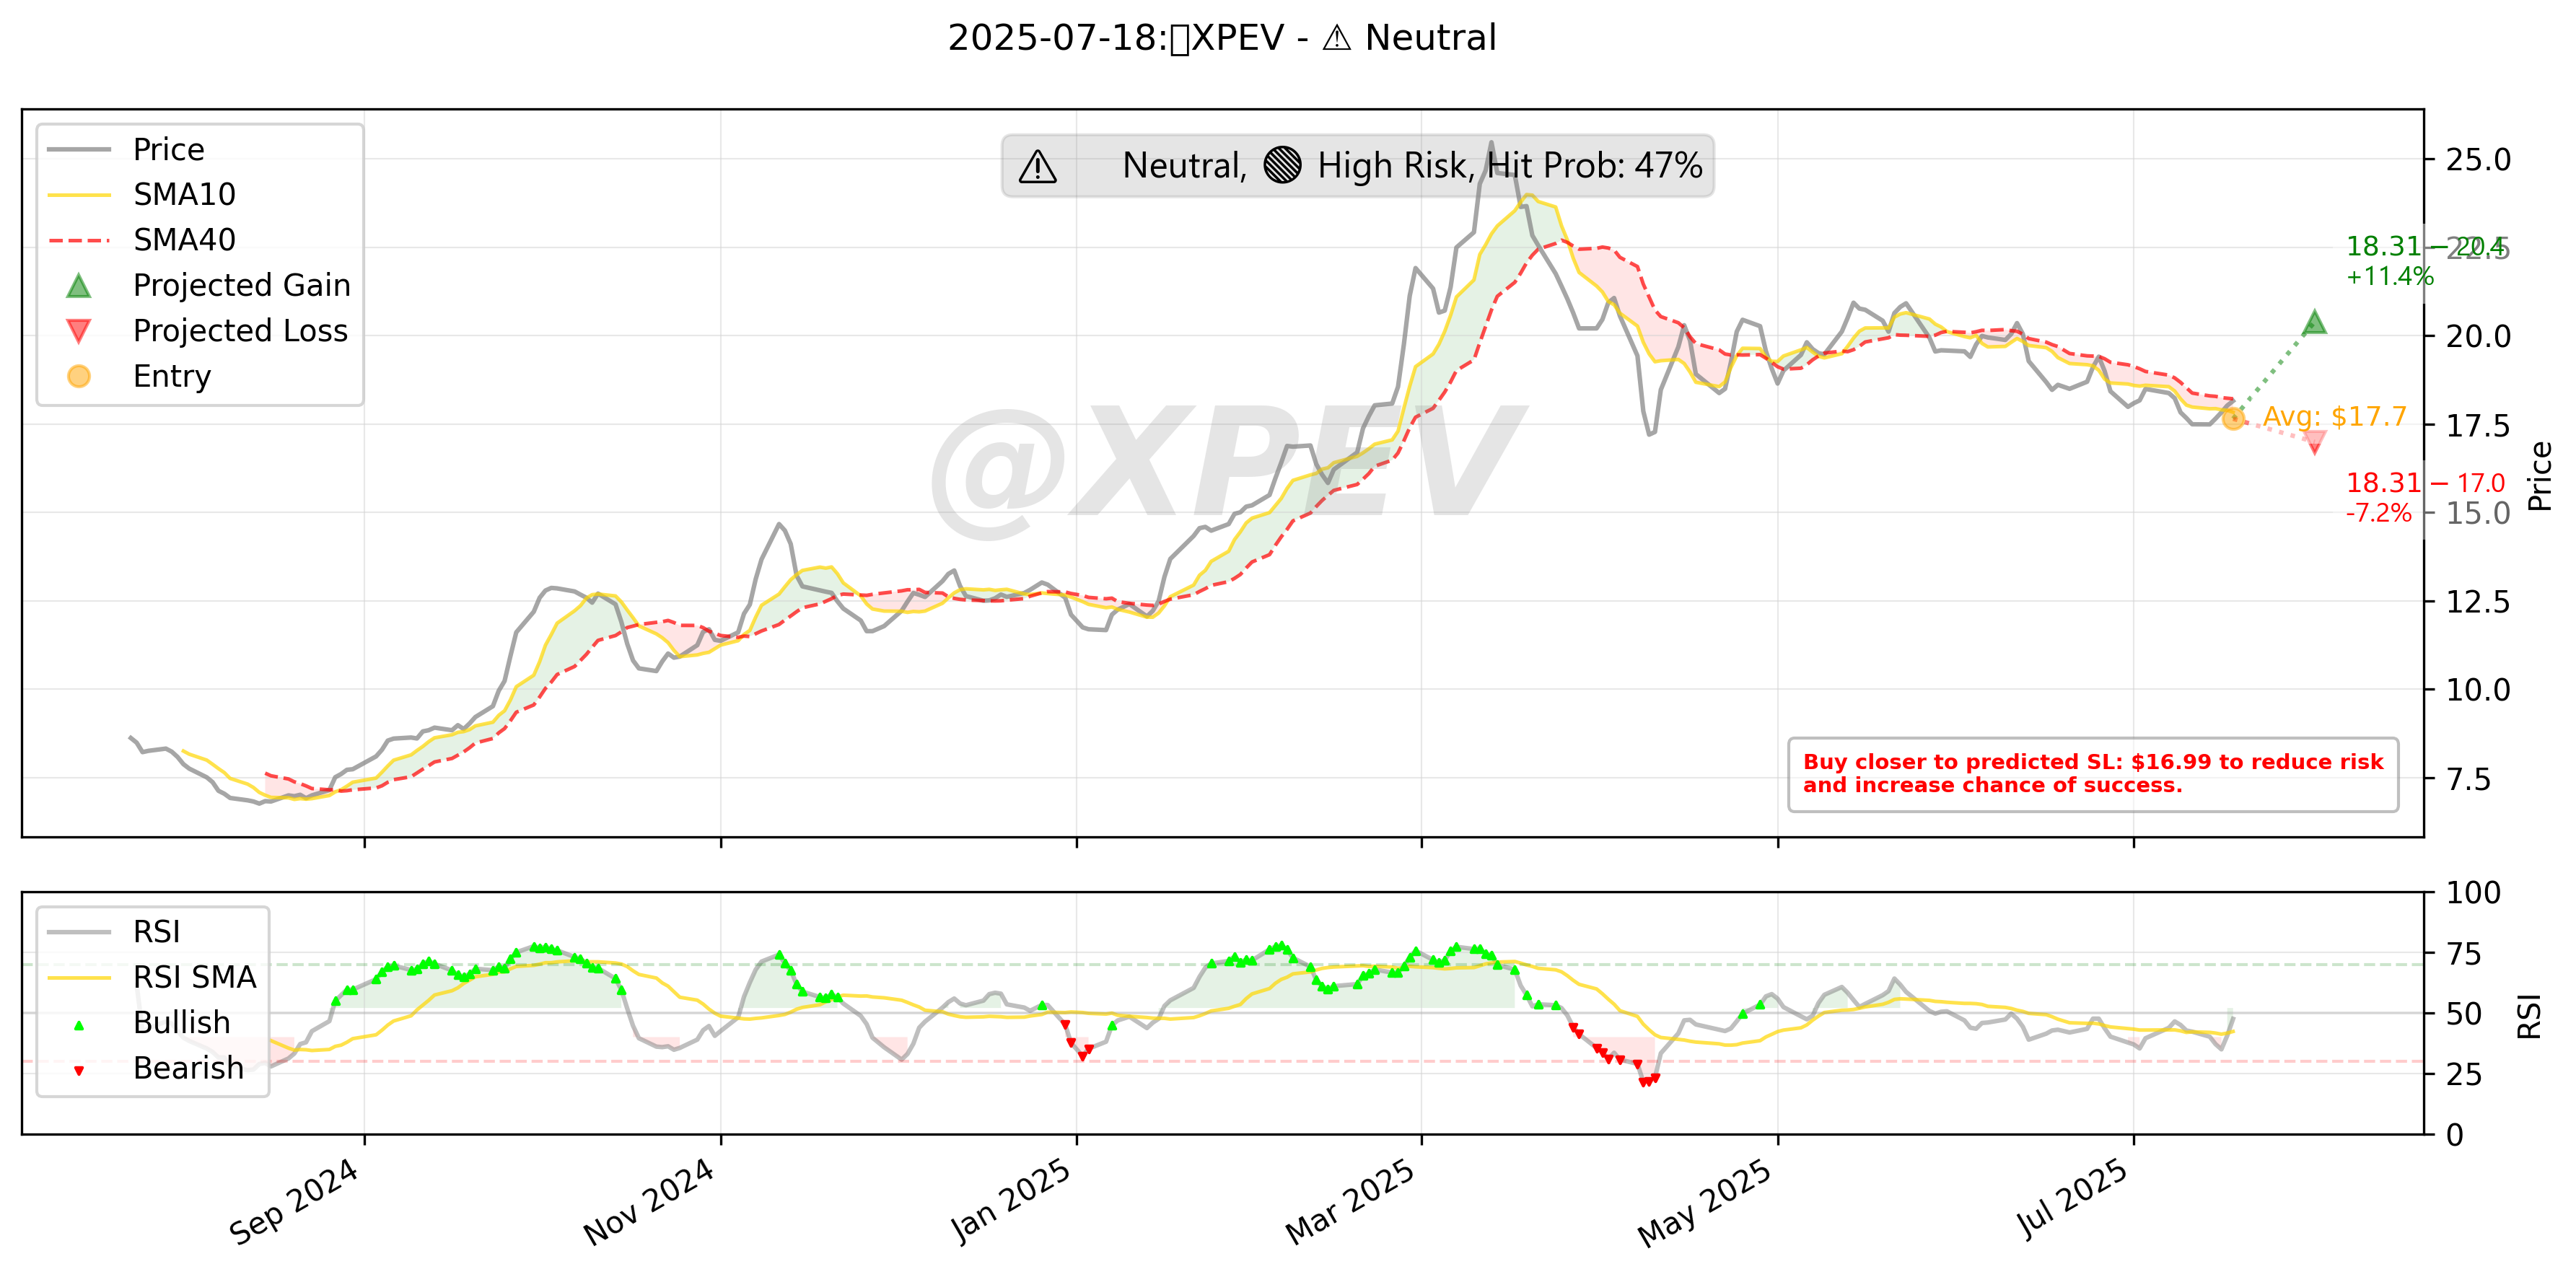

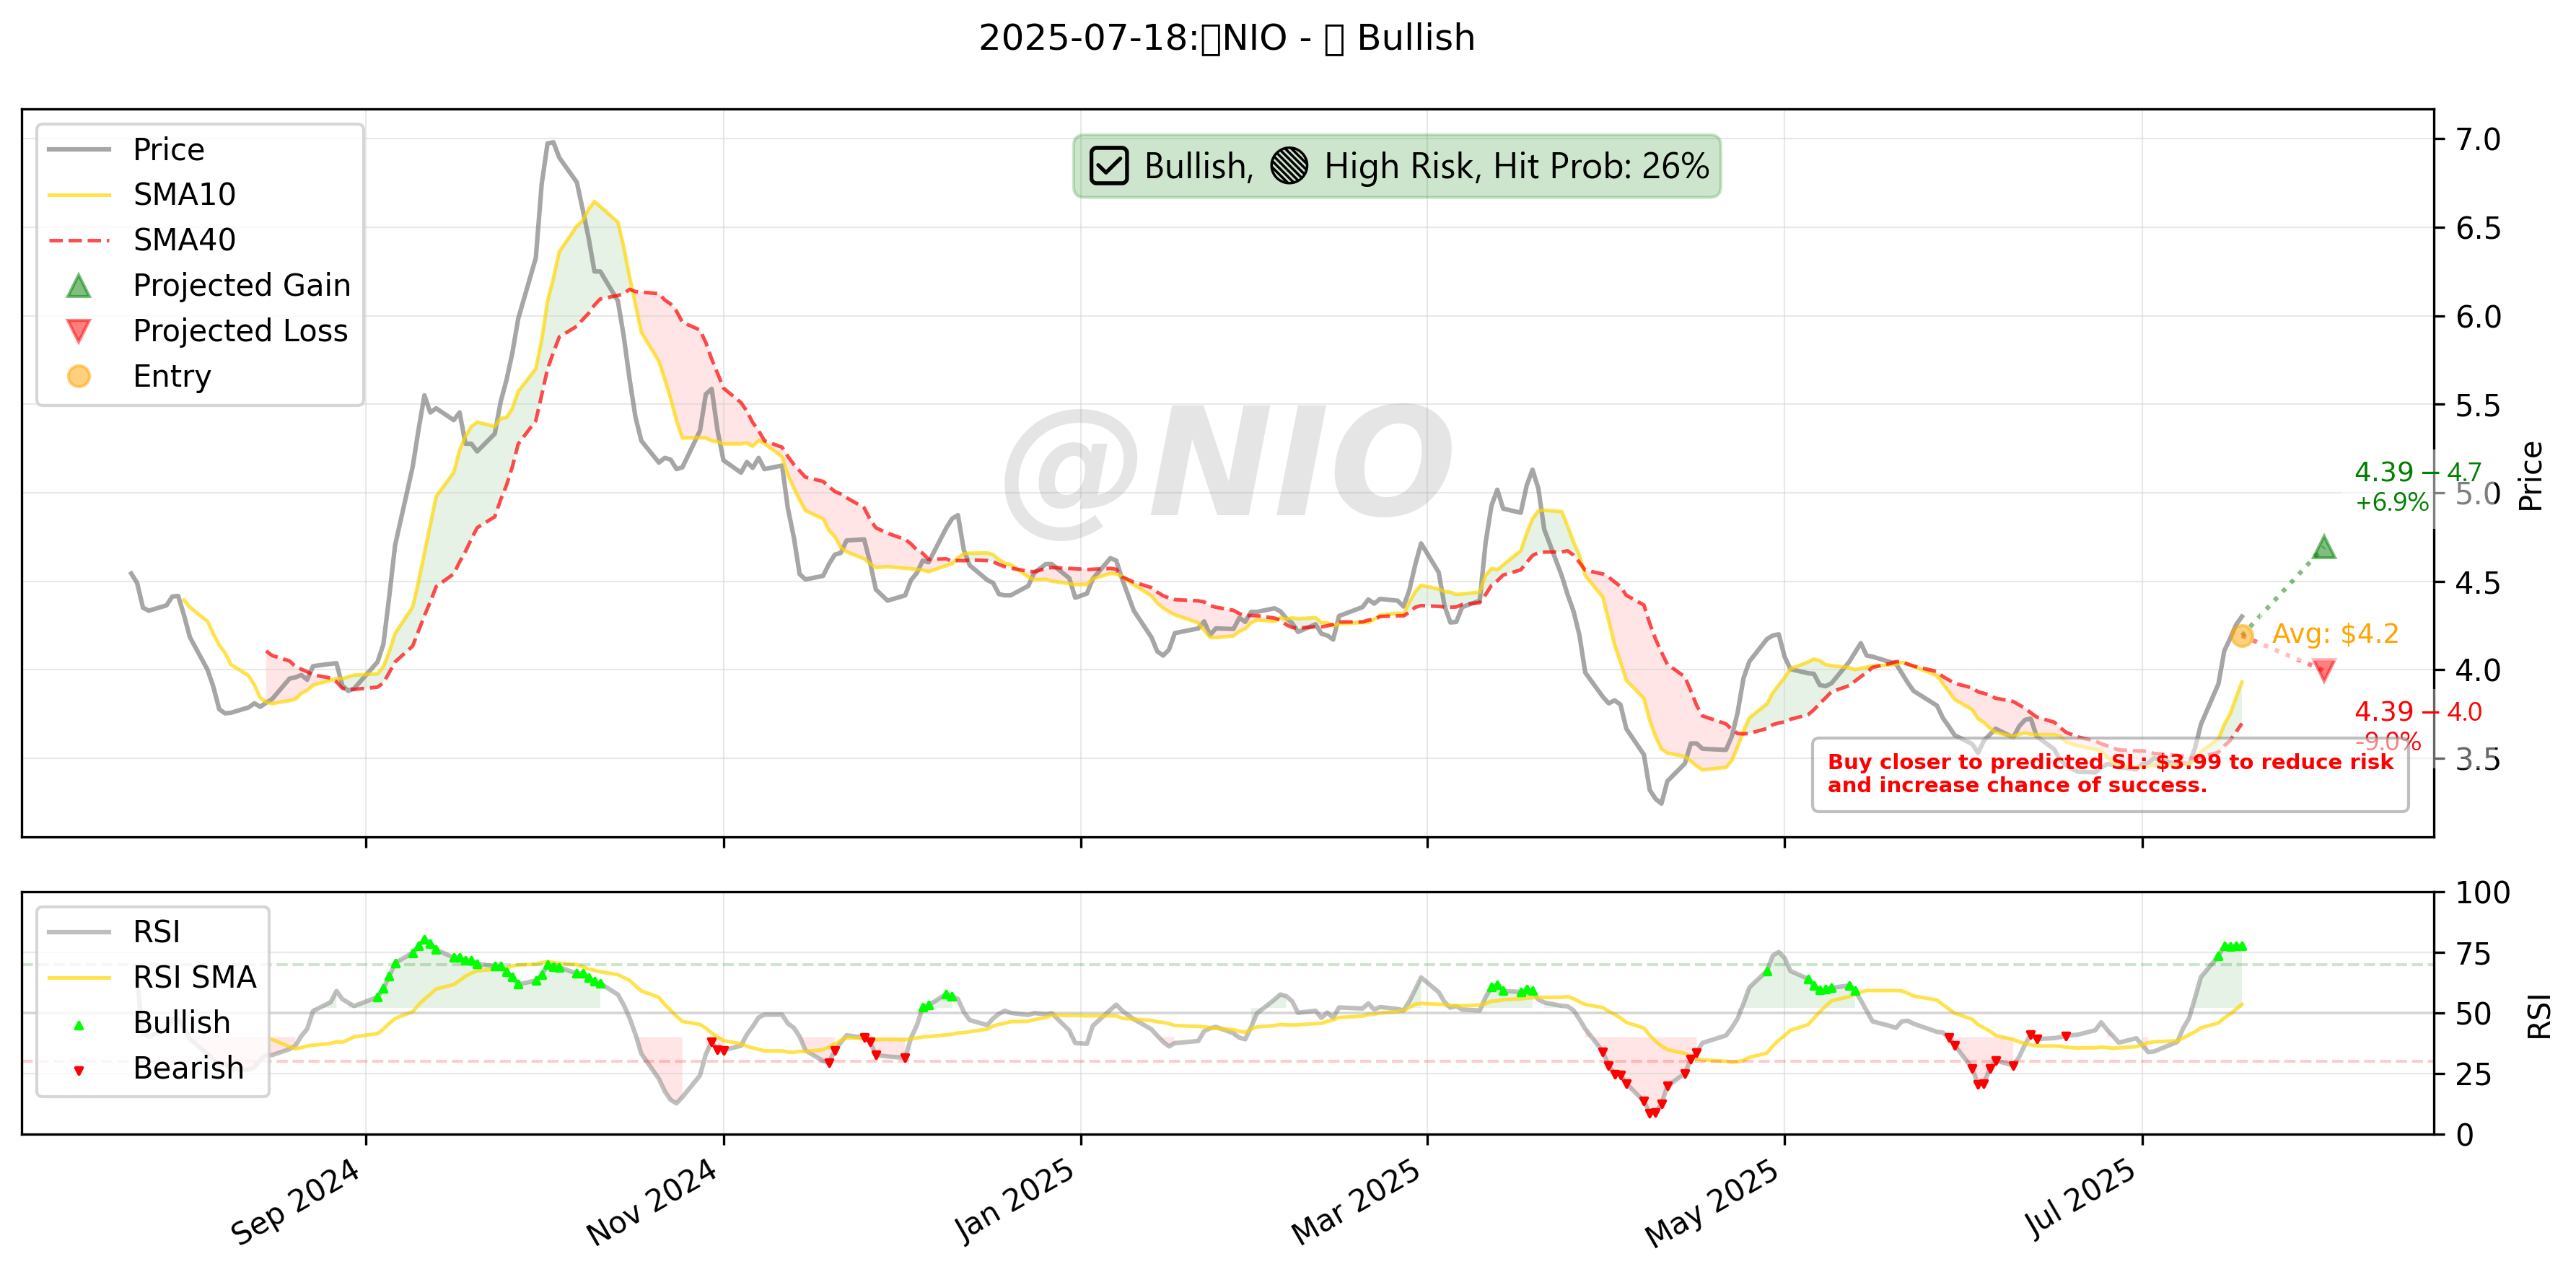

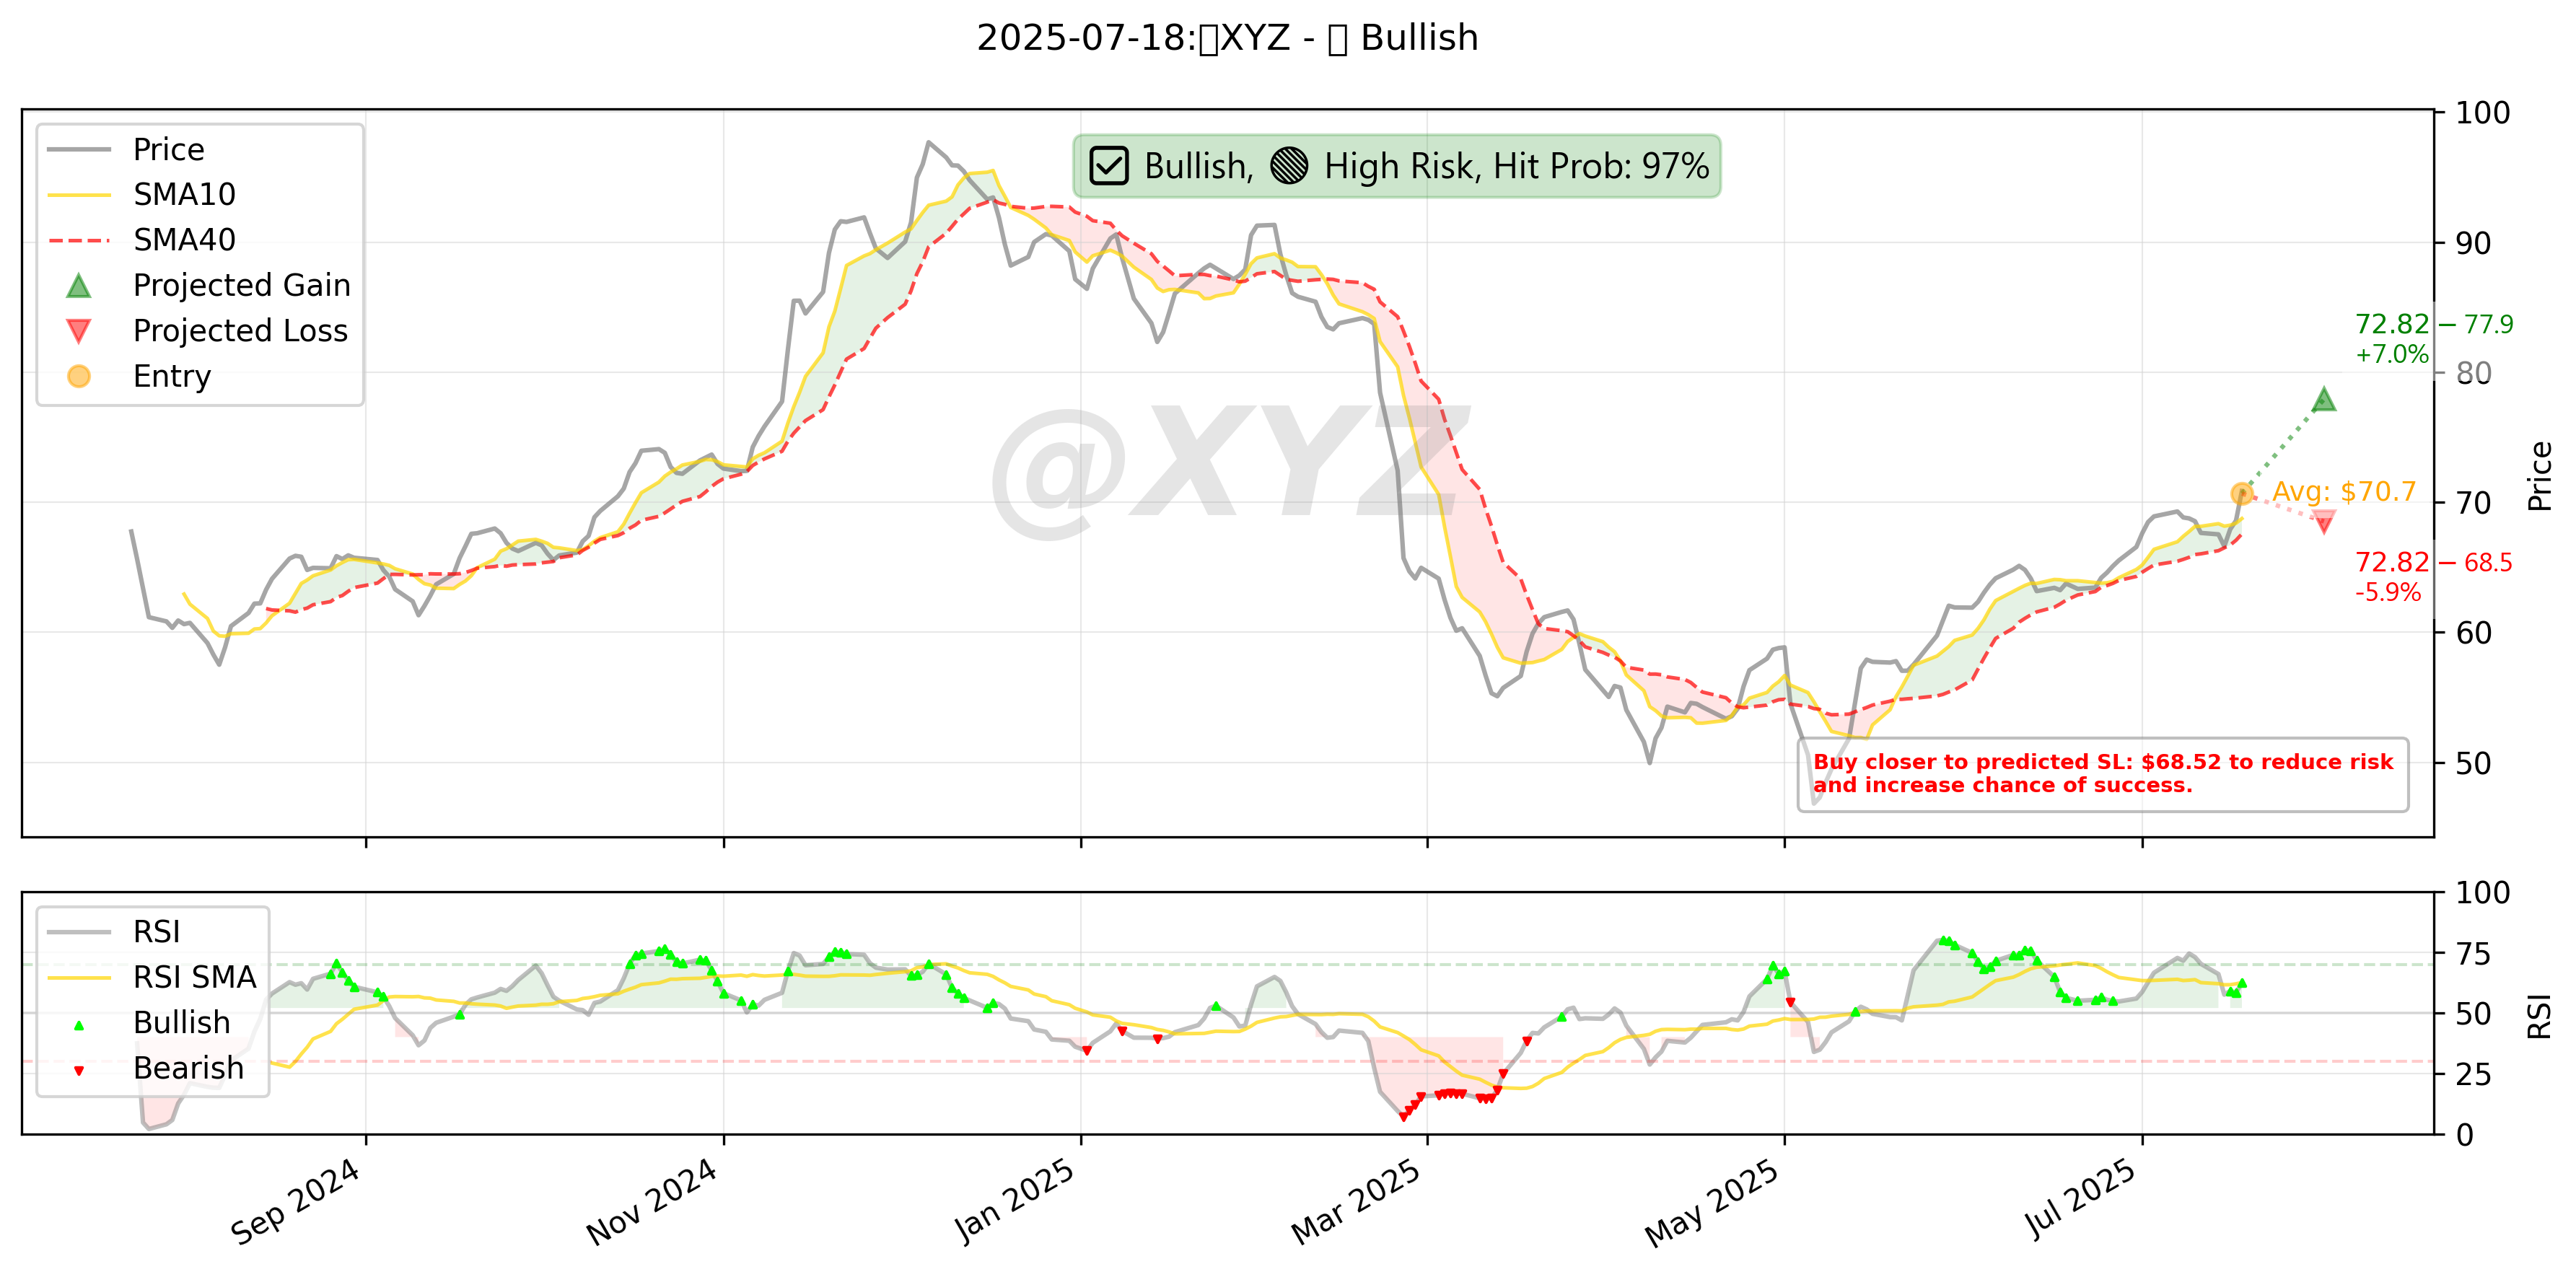

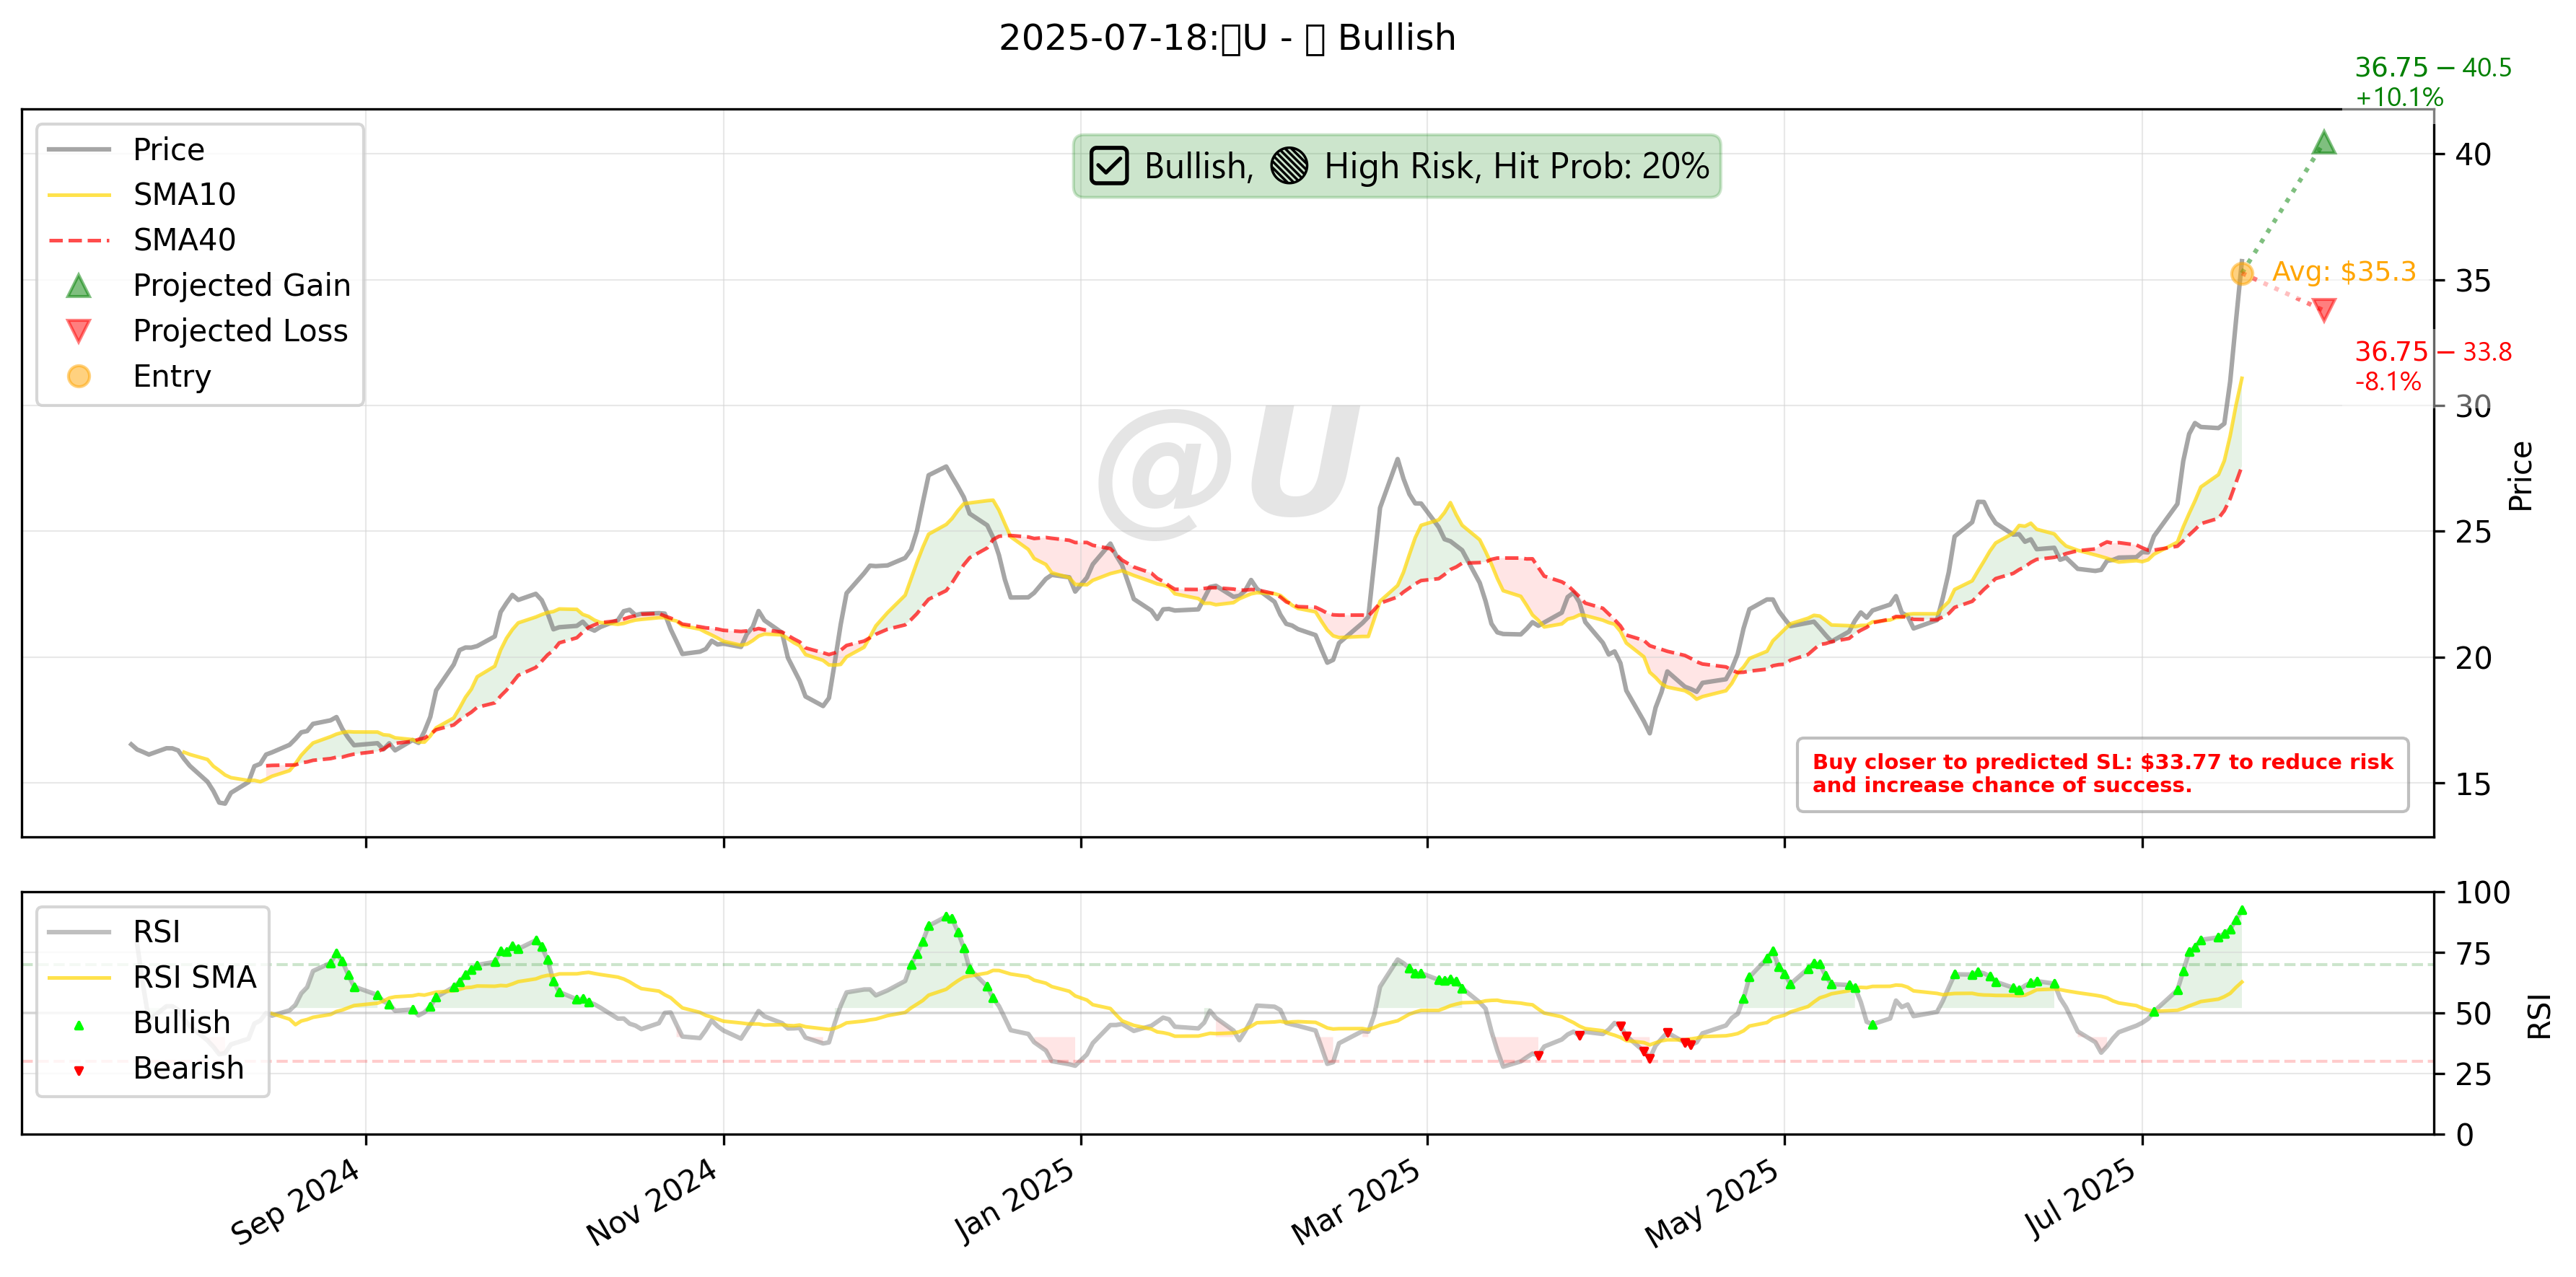



Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_AAPL_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_COIN_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_GOOGL_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_ML_PNL_MultiStocks.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_NIO_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_NKE_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_NVDA_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_SMCI_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_TSLA_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_UNH_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-03_XPEV_TPSL.png
Deleted: C:\Users\ammar\jupyter-notebooks\ML_TP_SL_Figures\2025-07-

In [8]:
# PLOT STOCK TA with Predictions
for stock in TICKERS:
    df_ticker = get_stock_data(stock, datetime.now()-timedelta(days=365), datetime.now())
    df_ticker = add_technical_indicators(df_ticker)
    plot_single_ticker(stock, df_ticker, df_results)
    print("\n")
    
del_old_files(path, 14)

## TEST PROFITABILITY

Only trading when the price is (1Yr):

a) Above SMA20 days

b) RSI above 50

c) SMA20 > SMA50 days

d) SL is fixed like 3 to 5 %.

In [9]:
import matplotlib.pyplot as plt

def plot_expected_return_loss(df, ticker):
    # Ensure no NaNs in plotting columns
    df_plot = df.dropna(subset=['Close', 'Expected_Return', 'Expected_Loss'])
    dates = df_plot.index

    # Calculate expected TP and SL levels
    expected_tp = df_plot['Close'] * (1 + df_plot['Expected_Return'])
    expected_sl = df_plot['Close'] * (1 + df_plot['Expected_Loss'])

    # Create figure and axes correctly using plt.subplots()
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    # Plot lines on the Axes object
    ax.plot(dates, df_plot['Close'], label='Close Price', color='gray', linewidth=1.5)
    ax.plot(dates, expected_tp, label='Expected TP', color='green', linestyle='--', linewidth=1.2)
    ax.plot(dates, expected_sl, label='Expected SL', color='red', linestyle='--', linewidth=1.2)

    ax.spines['right'].set_position(('outward', 0))
    ax.spines['right'].set_visible(True)
    
    # Optionally reposition ticks and tick labels on right
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('right')
    
    plt.show()
